In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import joblib
import os
import time
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from time import time
from statsmodels.tsa.stattools import kpss
from plotnine import *

# Load the datasets
chýbajúci_zub = pd.read_csv('missing_tooth.csv')
odštiepený_zub = pd.read_csv('tooth_chipped_fault.csv')
povrchová_chyba = pd.read_csv('surface_fault.csv')
bez_poruchy = pd.read_csv('no_fault.csv')
koreňová_trhlina = pd.read_csv('root_crack.csv')
výstrednosť = pd.read_csv('eccentricity.csv')

In [4]:
chýbajúci_zub['state'] = 'chýbajúci_zub'
odštiepený_zub['state'] = 'odštiepený_zub'
povrchová_chyba['state'] = 'povrchová_chyba'
bez_poruchy['state'] = 'bez_poruchy'
koreňová_trhlina['state'] = 'koreňová_trhlina'
výstrednosť['state'] = 'výstrednosť'

df = pd.concat([
    bez_poruchy,
    chýbajúci_zub, 
    odštiepený_zub,
    povrchová_chyba,
    koreňová_trhlina, 
    výstrednosť
])

#Normalize time_x grouped by state, load_value, speedSet
df['time_x'] = pd.to_datetime(df['time_x'])
df['time_normalized'] = df.groupby(['state', 'load_value', 'speedSet'])['time_x'].transform(lambda x: (x - x.min()).dt.total_seconds())


In [5]:
df['formated_time'] = pd.to_datetime(df.time_x, format="%Y-%m-%d %H:%M:%S.%f")

In [6]:
# Define the variables before using them
speedload_8_0 = df[(df['speedSet'] == 8.33203125) & (df['load_value'] == 0)].copy()
speedload_8_80 = df[(df['speedSet'] == 8.33203125) & (df['load_value'] == 80)].copy()
speedload_25_0 = df[(df['speedSet'] == 25) & (df['load_value'] == 0)].copy()
speedload_25_80 = df[(df['speedSet'] == 25) & (df['load_value'] == 80)].copy()
speedload_40_0 = df[(df['speedSet'] == 40) & (df['load_value'] == 0)].copy()
speedload_40_80 = df[(df['speedSet'] == 40) & (df['load_value'] == 80)].copy()


In [7]:
# Apply the KPSS test to each unique state for 'sensor1' values by 'normalized_time'.
def apply_kpss(series):
    kpss_stat, p_value, lags, crit = kpss(series, 'c')
    return kpss_stat, p_value, crit

# Apply the KPSS test to all unique states
unique_states = speedload_8_0['state'].unique()
kpss_results = {}
for state in unique_states:
    # Extracting the time series data for 'sensor1' for the current state
    time_series = speedload_8_0.loc[speedload_8_0['state'] == state, 'sensor1']
    # Applying KPSS test
    kpss_stat, p_value, crit = apply_kpss(time_series)
    kpss_results[state] = (kpss_stat, p_value, crit)

# You can print out the results or convert it to a DataFrame
kpss_results_df = pd.DataFrame(kpss_results, index=['KPSS Štatistica', 'p-hodnota', 'Kritické hodnoty']).T
print(kpss_results_df)

                 KPSS Štatistica p-hodnota  \
bez_poruchy             2.016985      0.01   
chýbajúci_zub           0.098826       0.1   
odštiepený_zub          3.135916      0.01   
povrchová_chyba         0.374733  0.088046   
koreňová_trhlina        9.098141      0.01   
výstrednosť             1.742396      0.01   

                                                   Kritické hodnoty  
bez_poruchy       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
chýbajúci_zub     {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
odštiepený_zub    {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
povrchová_chyba   {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
koreňová_trhlina  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
výstrednosť       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  


C:\Users\rober\AppData\Local\Temp\ipykernel_8728\36392788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_8728\36392788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_8728\36392788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_8728\36392788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_8728\36392788.py:3: Interpolatio

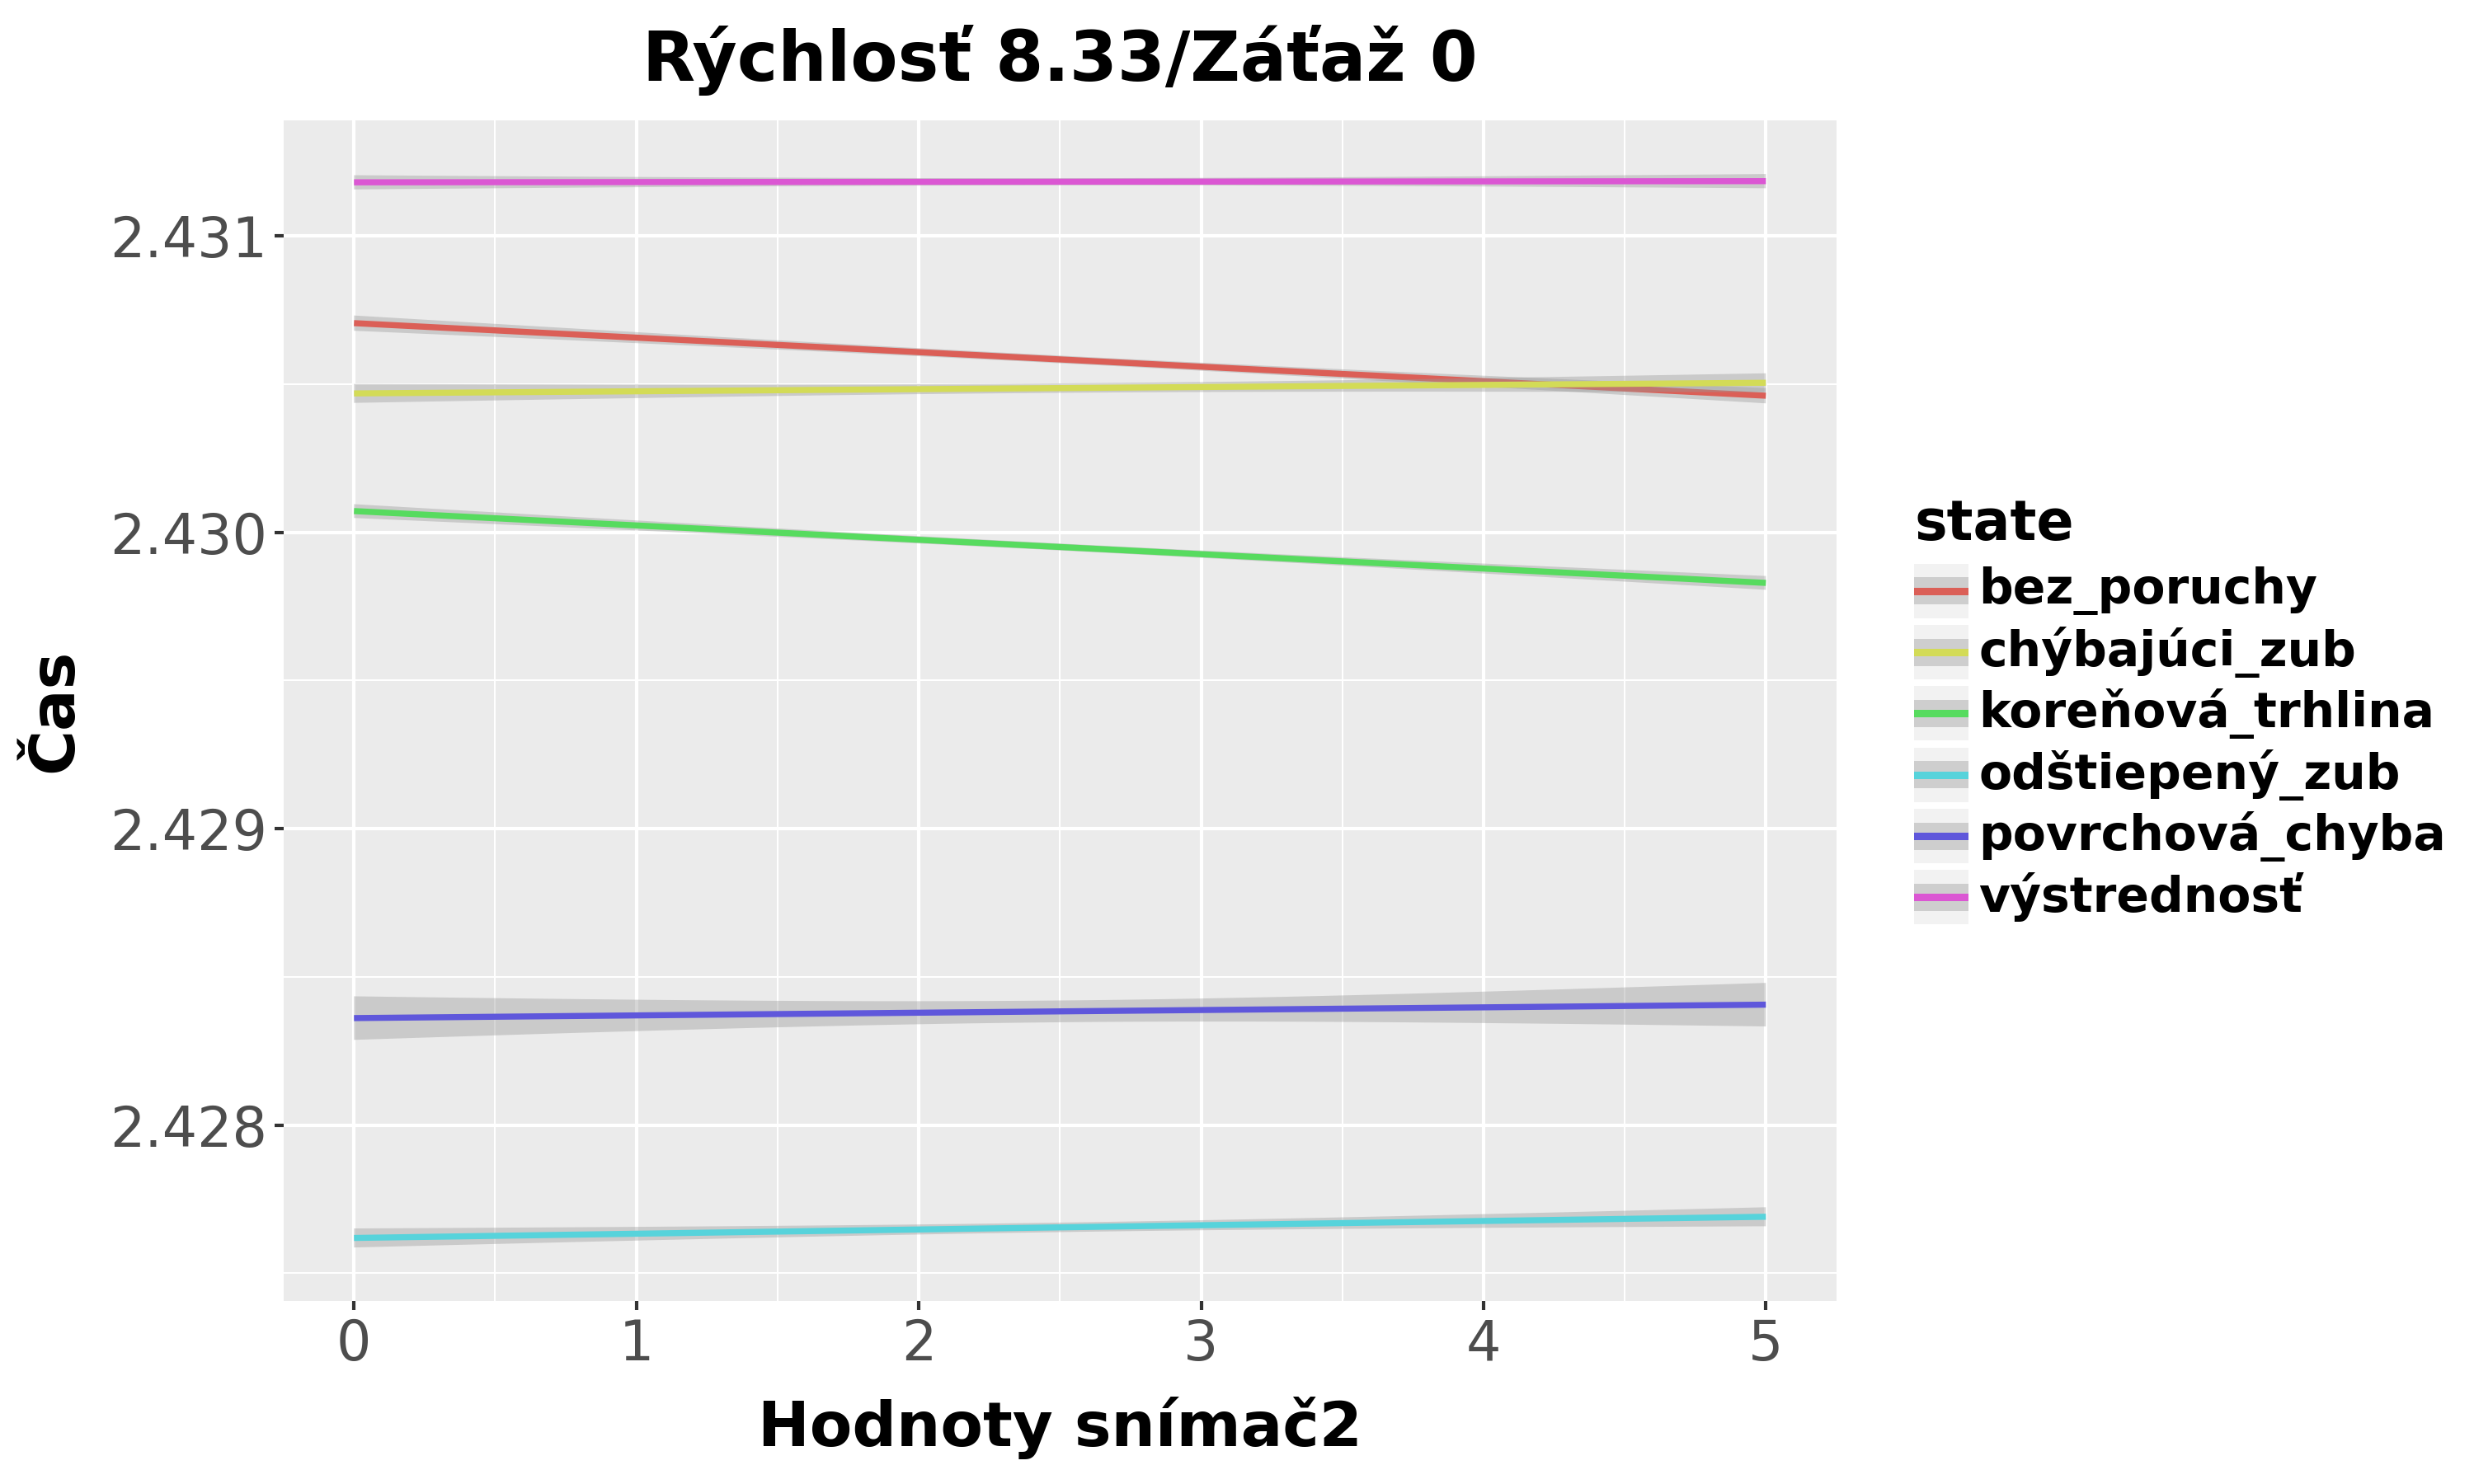

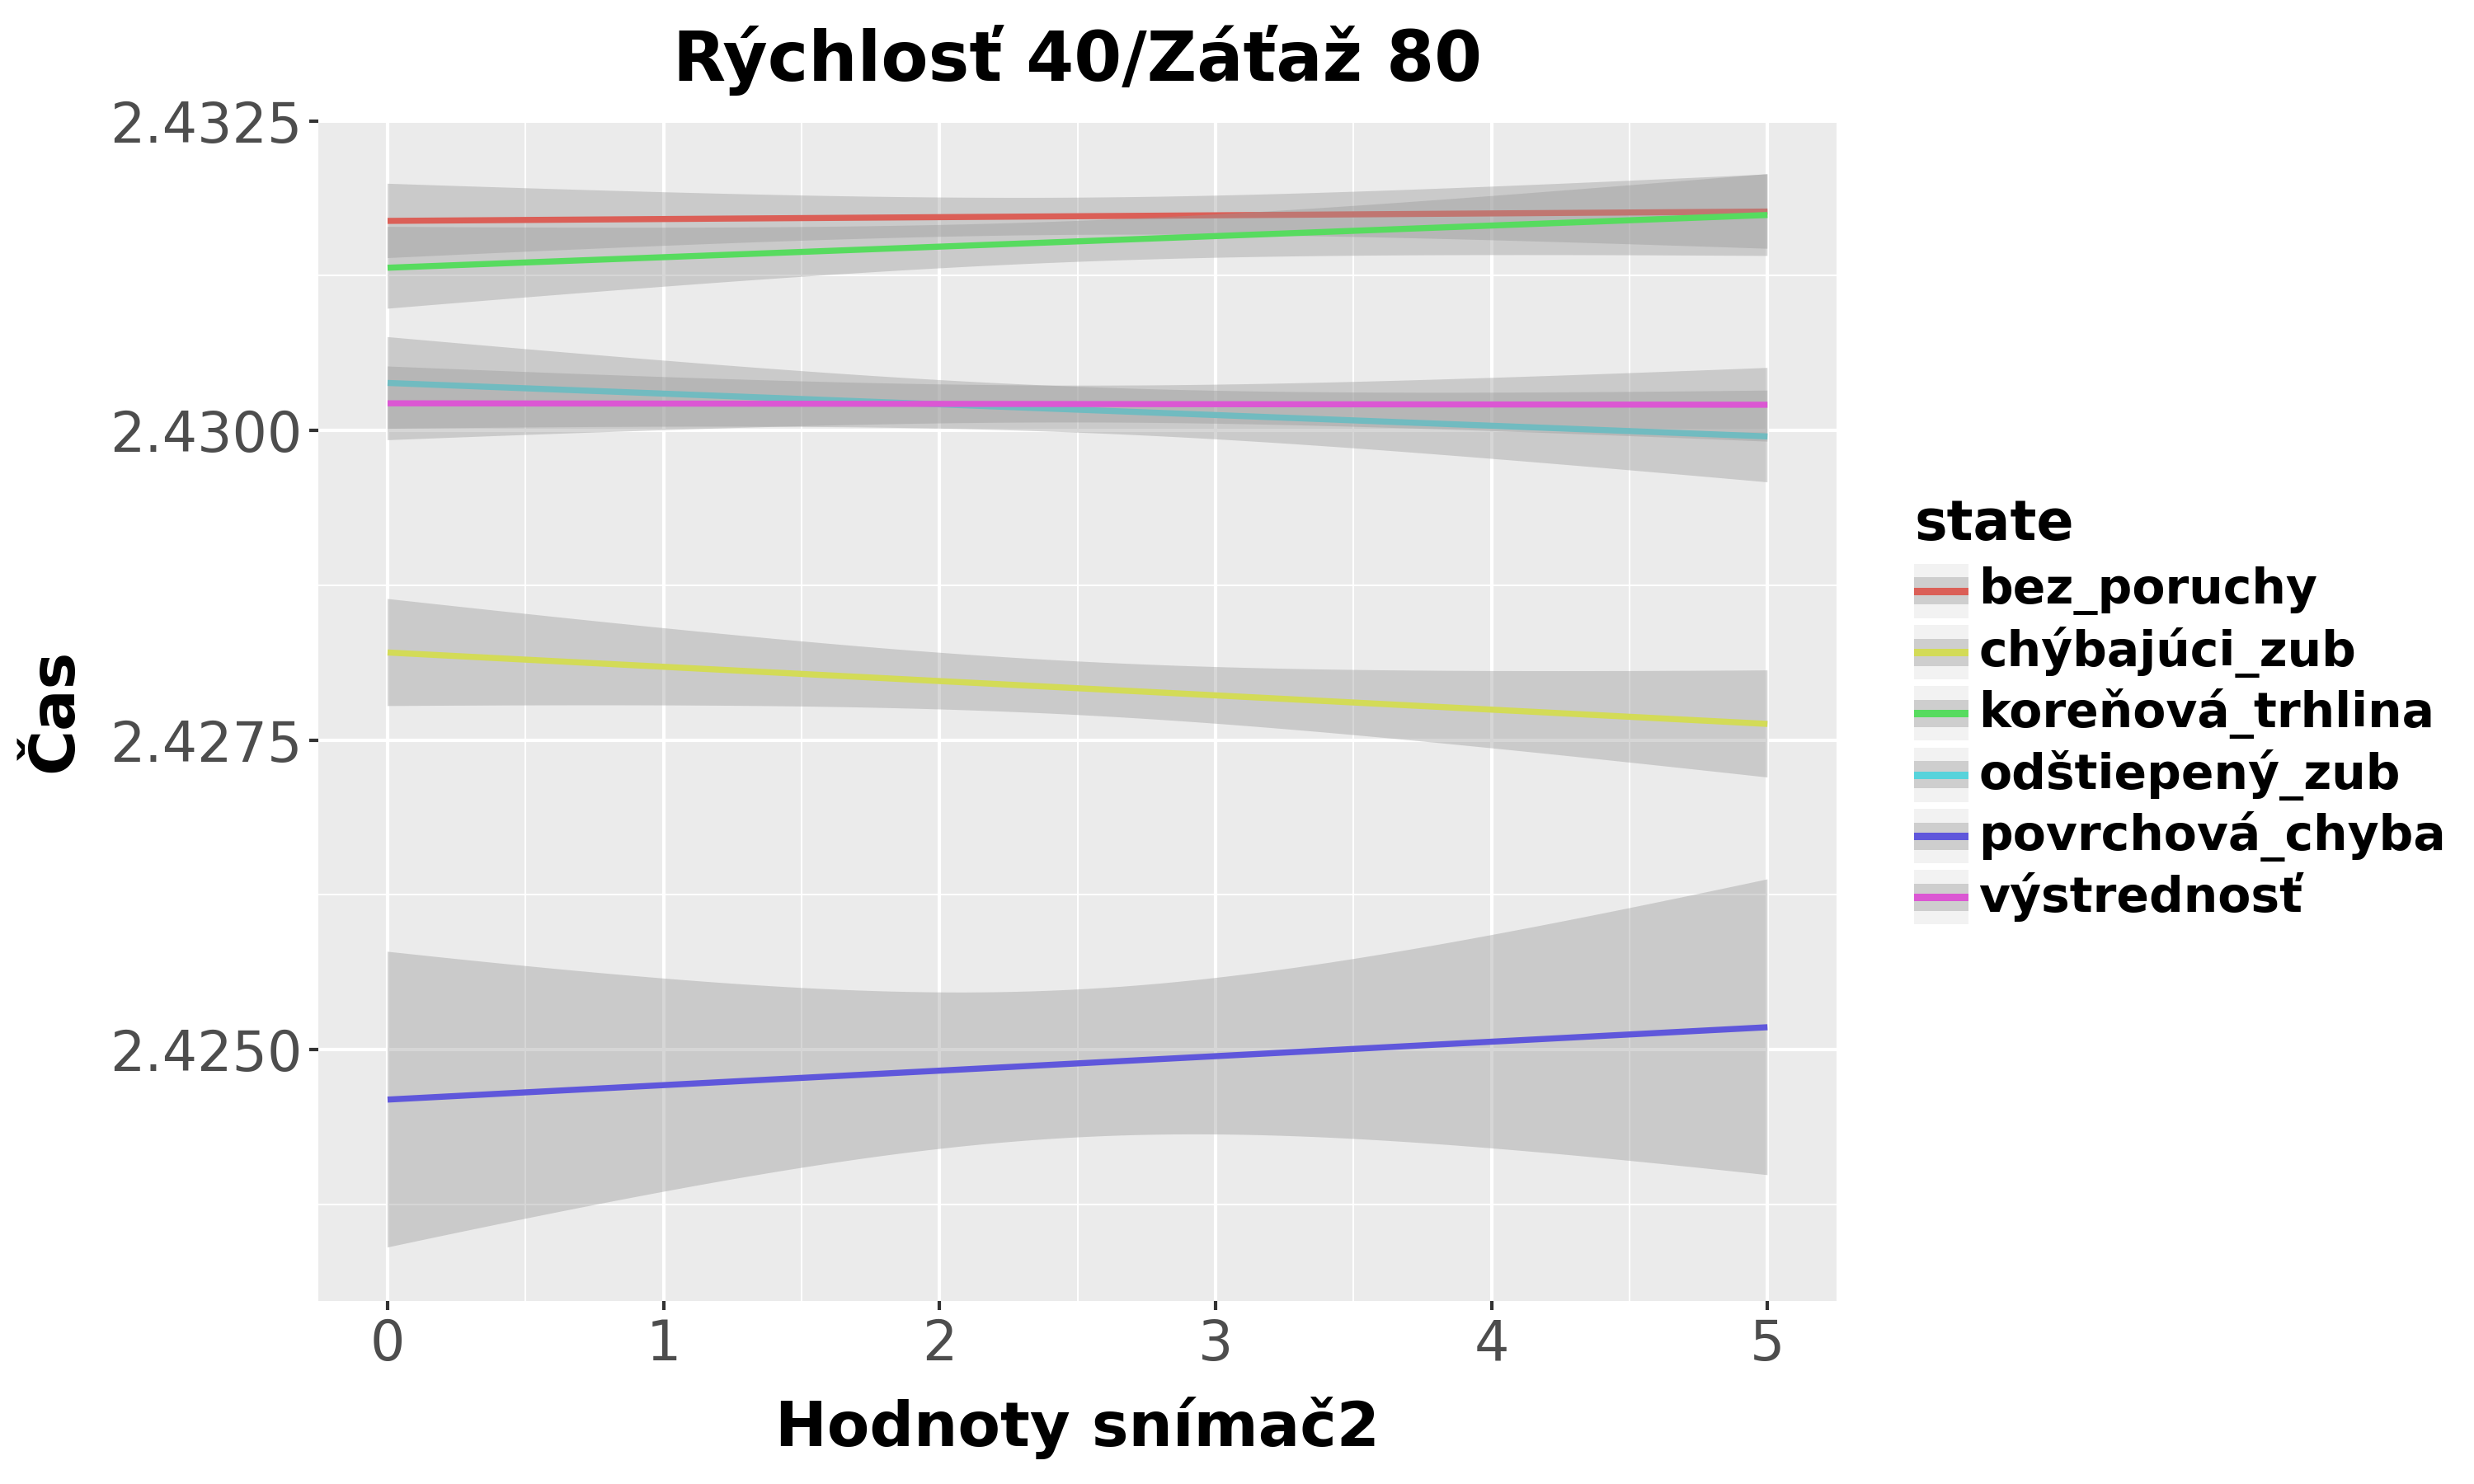

In [8]:
from plotnine import *

display(ggplot(data=speedload_8_0, mapping=aes(x='time_normalized', y='sensor2', color='state')) + geom_smooth() + 
        ggtitle('Rýchlosť 8.33/Záťaž 0') +
        labs(x='Hodnoty snímač2', y='Čas', fill='Stav') +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_40_80, mapping=aes(x='time_normalized', y='sensor2', color='state')) + geom_smooth() + 
        ggtitle('Rýchlosť 40/Záťaž 80') +
        labs(x='Hodnoty snímač2', y='Čas', fill='Stav') +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))


c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 2915 rows containing non-finite values.
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 2915 rows containing non-finite values.


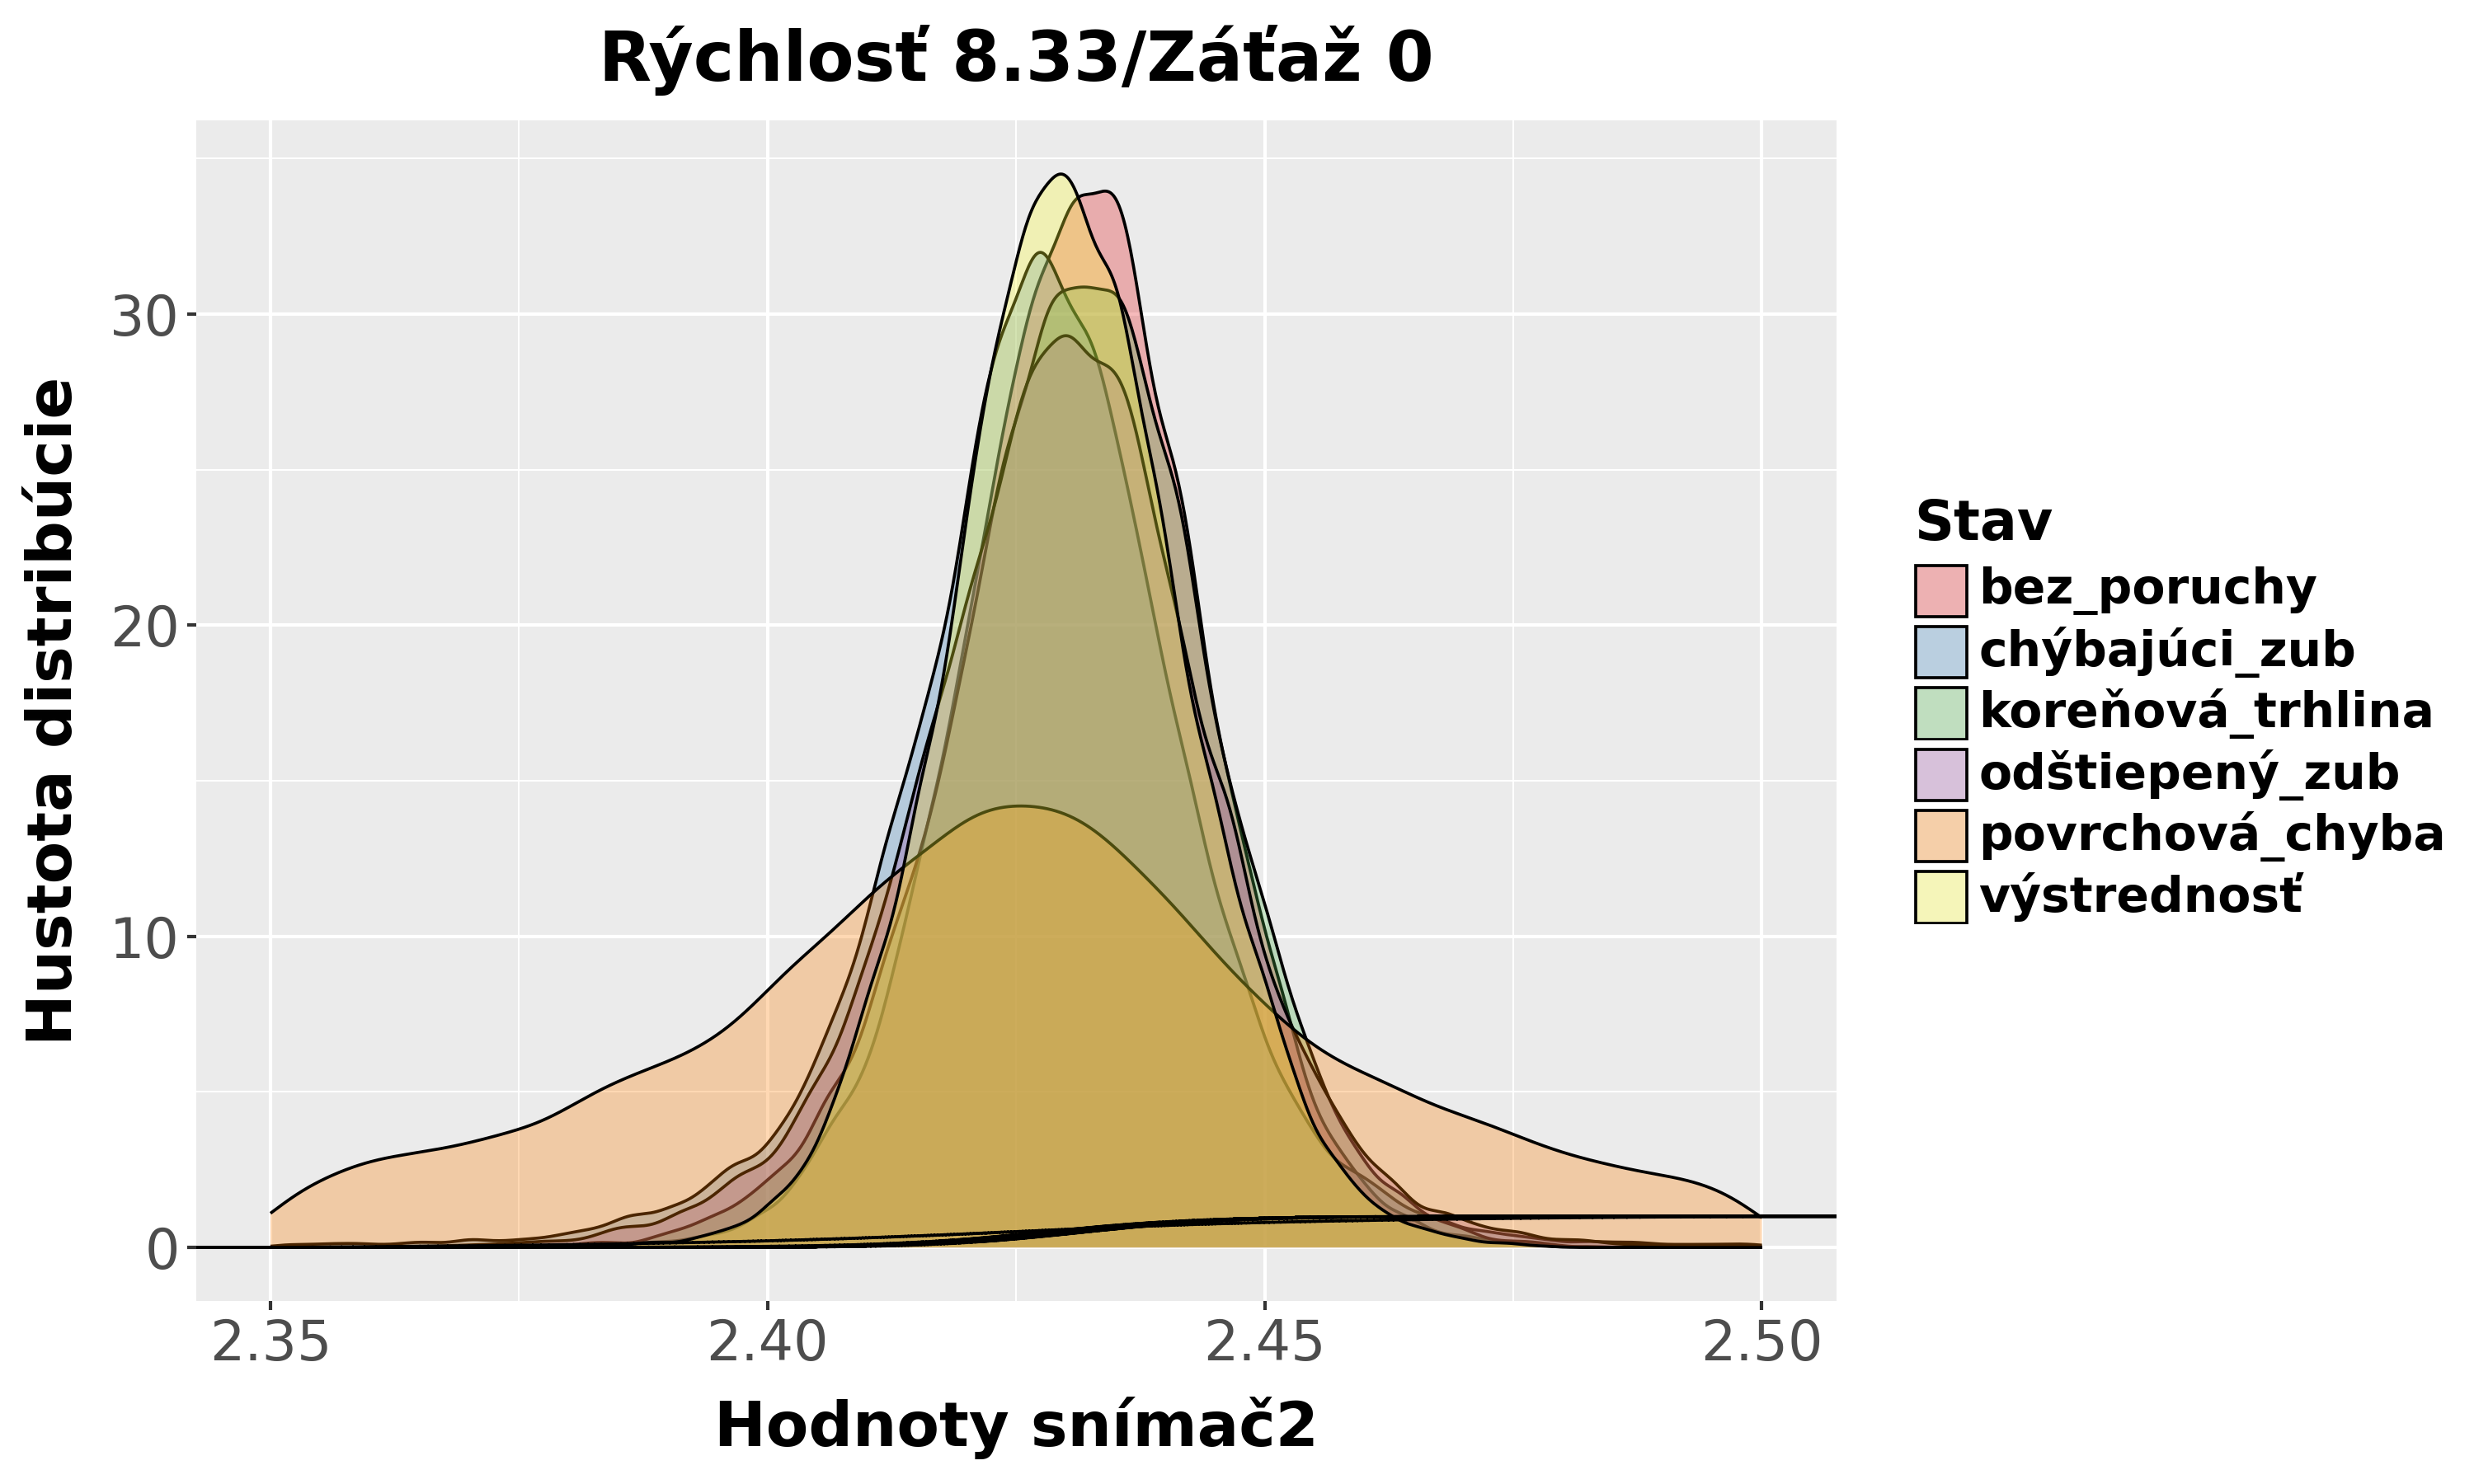

c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 732 rows containing non-finite values.
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 732 rows containing non-finite values.


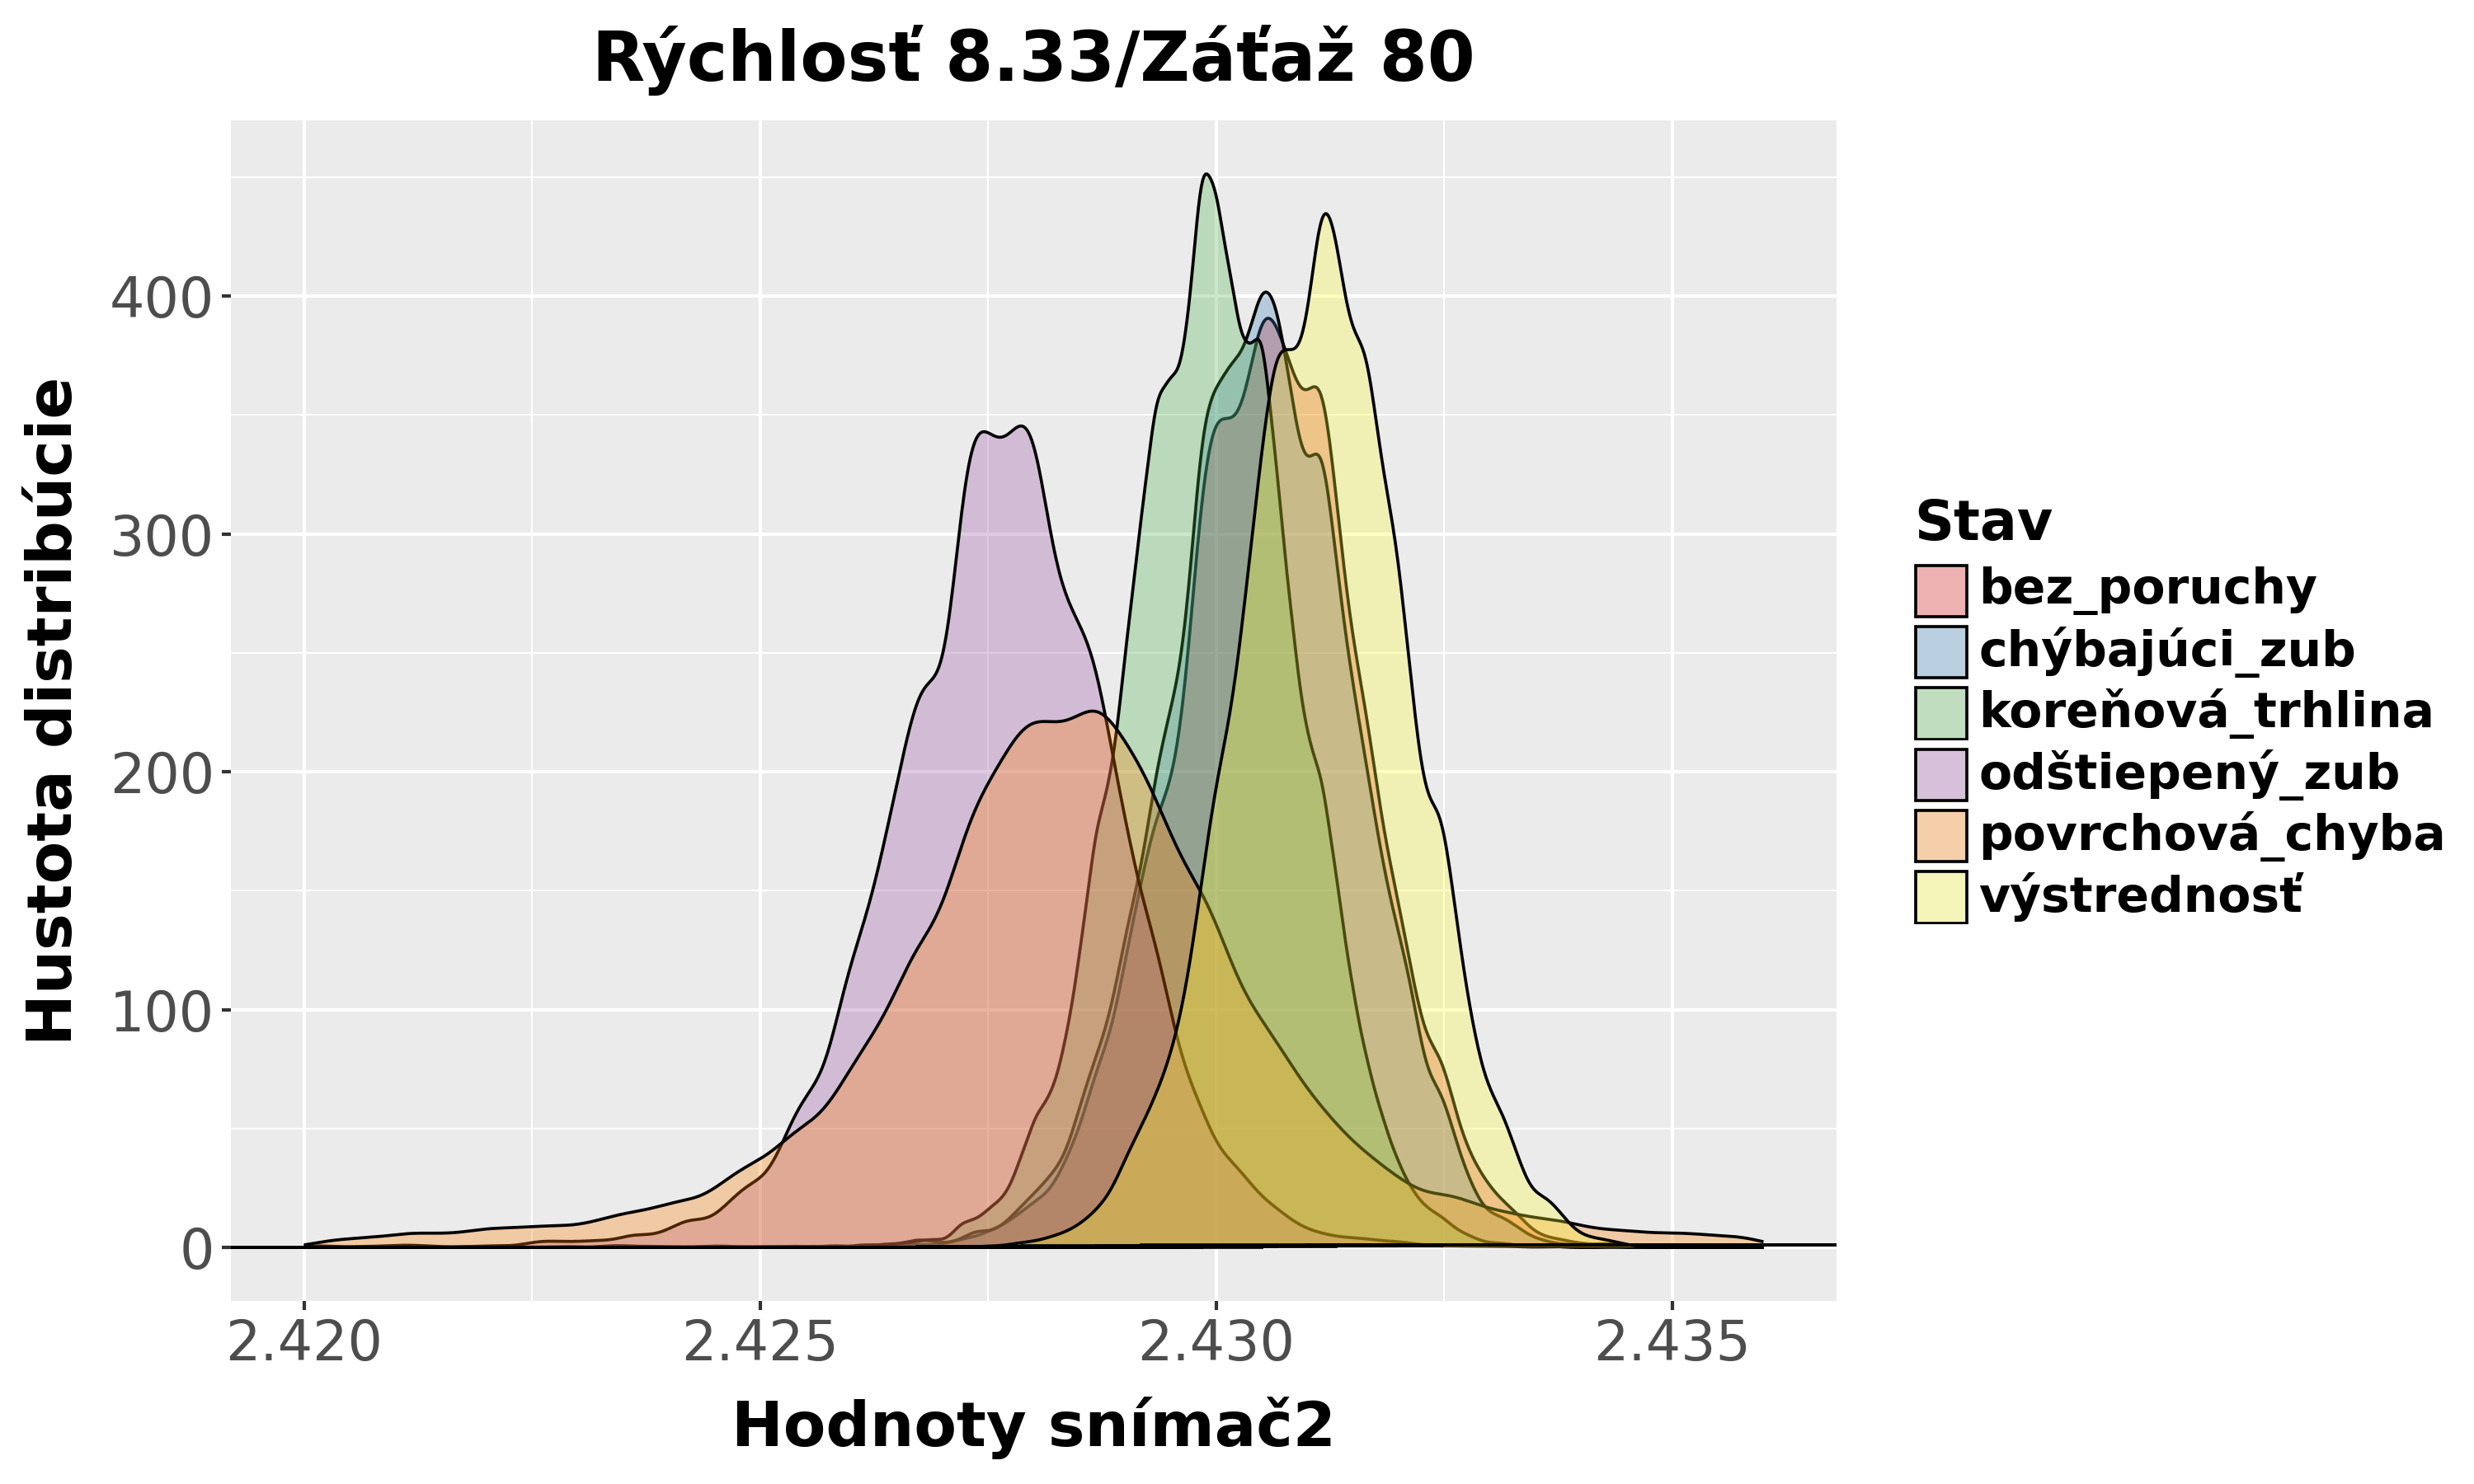

In [9]:
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']

display(ggplot(data=speedload_40_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33/Záťaž 0') +
        labs(x='Hodnoty snímač2', y='Hustota distribúcie', fill='Stav') + xlim(2.35, 2.5) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_8_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33/Záťaž 80') +
        labs(x='Hodnoty snímač2', y='Hustota distribúcie', fill='Stav') + xlim(2.42, 2.436) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))

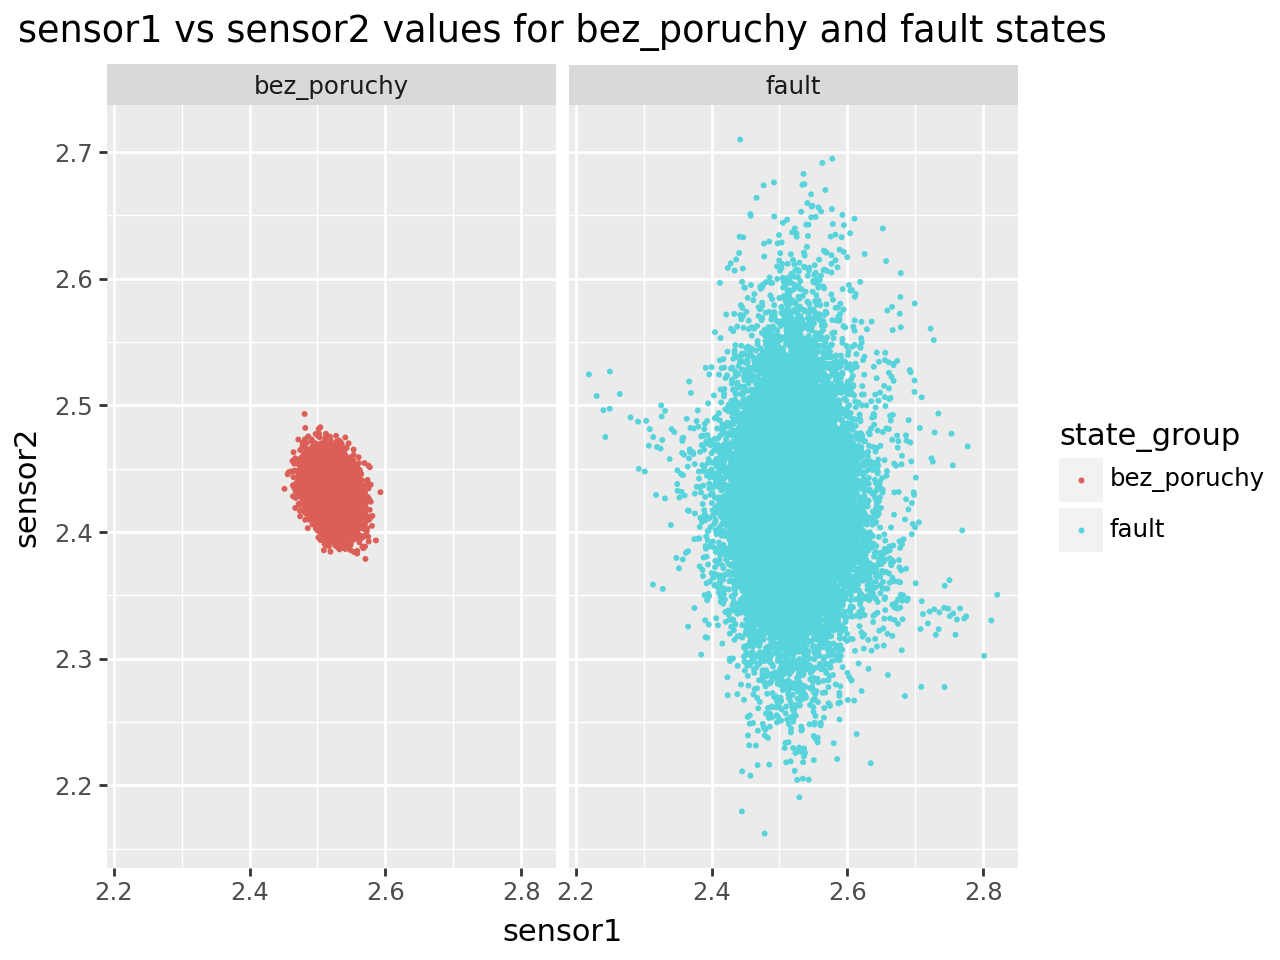

In [10]:
from plotnine import ggplot, aes, geom_point, facet_wrap, ggtitle
# Plot state column sensor values as bez_poruchy against other '~bez_poruchy' values
df_news = df.copy()
df_news['state_group'] = df_news['state'].apply(lambda x: 'bez_poruchy' if x == 'bez_poruchy' else 'fault')
display(ggplot(df_news, aes(x='sensor1', y='sensor2', color='state_group')) + geom_point(size=0.2) + facet_wrap('~state_group') + ggtitle('sensor1 vs sensor2 values for bez_poruchy and fault states'))


In [11]:
# Example data setup (replace or adjust based on your actual dataframe 'df')
df['state_expected'] = df.state.apply(lambda x: ['bez_poruchy', 'chýbajúci_zub', 'odštiepený_zub', 'povrchová_chyba', 'koreňová_trhlina', 'výstrednosť'].index(x))

# Creating a dictionary for the transformation
mapping_dict = df.set_index('state_expected')['state'].to_dict()

# Correctly creating DataFrame from dictionary
state_expected_keys = pd.DataFrame(list(mapping_dict.items()), columns=['state_expected', 'state'])
display(state_expected_keys)
# Creating a new DataFrame without certain columns
df_edit = df[['sensor1', 'sensor2', 'speedSet', 'load_value', 'state_expected', 'time_normalized']].copy()

,state_expected,state
0,0,bez_poruchy
1,1,chýbajúci_zub
2,2,odštiepený_zub
3,3,povrchová_chyba
4,4,koreňová_trhlina
5,5,výstrednosť


In [12]:
df_edit['sample'] = df_edit.time_normalized < 4

df_edit['sensor1_25_max'] = df_edit['sensor1'].rolling(window=25, min_periods=1).max()
df_edit['sensor1_25_min'] = df_edit['sensor1'].rolling(window=25, min_periods=1).min()
df_edit['sensor1_25_mean'] = df_edit['sensor1'].rolling(window=25, min_periods=1).mean()
df_edit['sensor1_25_std'] = df_edit['sensor1'].rolling(window=25, min_periods=1).std()
df_edit['sensor1_25_median'] = df_edit['sensor1'].rolling(window=25, min_periods=1).median()

df_edit['sensor2_25_max'] = df_edit['sensor2'].rolling(window=25, min_periods=1).max()
df_edit['sensor2_25_min'] = df_edit['sensor2'].rolling(window=25, min_periods=1).min()
df_edit['sensor2_25_mean'] = df_edit['sensor2'].rolling(window=25, min_periods=1).mean()
df_edit['sensor2_25_std'] = df_edit['sensor2'].rolling(window=25, min_periods=1).std()
df_edit['sensor2_25_median'] = df_edit['sensor2'].rolling(window=25, min_periods=1).median()

df_edit['sensor1_50_max'] = df_edit['sensor1'].rolling(window=50, min_periods=1).max()
df_edit['sensor1_50_min'] = df_edit['sensor1'].rolling(window=50, min_periods=1).min()
df_edit['sensor1_50_mean'] = df_edit['sensor1'].rolling(window=50, min_periods=1).mean()
df_edit['sensor1_50_std'] = df_edit['sensor1'].rolling(window=50, min_periods=1).std()
df_edit['sensor1_50_median'] = df_edit['sensor1'].rolling(window=50, min_periods=1).median()

df_edit['sensor2_50_max'] = df_edit['sensor2'].rolling(window=50, min_periods=1).max()
df_edit['sensor2_50_min'] = df_edit['sensor2'].rolling(window=50, min_periods=1).min()
df_edit['sensor2_50_mean'] = df_edit['sensor2'].rolling(window=50, min_periods=1).mean()
df_edit['sensor2_50_std'] = df_edit['sensor2'].rolling(window=50, min_periods=1).std()
df_edit['sensor2_50_median'] = df_edit['sensor2'].rolling(window=50, min_periods=1).median()

df_edit['sensor1_100_max'] = df_edit['sensor1'].rolling(window=100, min_periods=1).max()
df_edit['sensor1_100_min'] = df_edit['sensor1'].rolling(window=100, min_periods=1).min()
df_edit['sensor1_100_mean'] = df_edit['sensor1'].rolling(window=100, min_periods=1).mean()
df_edit['sensor1_100_std'] = df_edit['sensor1'].rolling(window=100, min_periods=1).std()
df_edit['sensor1_100_median'] = df_edit['sensor1'].rolling(window=100, min_periods=1).median()

df_edit['sensor2_100_max'] = df_edit['sensor2'].rolling(window=100, min_periods=1).max()
df_edit['sensor2_100_min'] = df_edit['sensor2'].rolling(window=100, min_periods=1).min()
df_edit['sensor2_100_mean'] = df_edit['sensor2'].rolling(window=100, min_periods=1).mean()
df_edit['sensor2_100_std'] = df_edit['sensor2'].rolling(window=100, min_periods=1).std()
df_edit['sensor2_100_median'] = df_edit['sensor2'].rolling(window=100, min_periods=1).median()

df_edit['sensor1_200_max'] = df_edit['sensor1'].rolling(window=200, min_periods=1).max()
df_edit['sensor1_200_min'] = df_edit['sensor1'].rolling(window=200, min_periods=1).min()
df_edit['sensor1_200_mean'] = df_edit['sensor1'].rolling(window=200, min_periods=1).mean()
df_edit['sensor1_200_std'] = df_edit['sensor1'].rolling(window=200, min_periods=1).std()
df_edit['sensor1_200_median'] = df_edit['sensor1'].rolling(window=200, min_periods=1).median()

df_edit['sensor2_200_max'] = df_edit['sensor2'].rolling(window=200, min_periods=1).max()
df_edit['sensor2_200_min'] = df_edit['sensor2'].rolling(window=200, min_periods=1).min()
df_edit['sensor2_200_mean'] = df_edit['sensor2'].rolling(window=200, min_periods=1).mean()
df_edit['sensor2_200_std'] = df_edit['sensor2'].rolling(window=200, min_periods=1).std()
df_edit['sensor2_200_median'] = df_edit['sensor2'].rolling(window=200, min_periods=1).median()

df_edit['sensor1_400_max'] = df_edit['sensor1'].rolling(window=400, min_periods=1).max()
df_edit['sensor1_400_min'] = df_edit['sensor1'].rolling(window=400, min_periods=1).min()
df_edit['sensor1_400_mean'] = df_edit['sensor1'].rolling(window=400, min_periods=1).mean()
df_edit['sensor1_400_std'] = df_edit['sensor1'].rolling(window=400, min_periods=1).std()
df_edit['sensor1_400_median'] = df_edit['sensor1'].rolling(window=400, min_periods=1).median()

df_edit['sensor2_400_max'] = df_edit['sensor2'].rolling(window=400, min_periods=1).max()
df_edit['sensor2_400_min'] = df_edit['sensor2'].rolling(window=400, min_periods=1).min()
df_edit['sensor2_400_mean'] = df_edit['sensor2'].rolling(window=400, min_periods=1).mean()
df_edit['sensor2_400_std'] = df_edit['sensor2'].rolling(window=400, min_periods=1).std()
df_edit['sensor2_400_median'] = df_edit['sensor2'].rolling(window=400, min_periods=1).median()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Choose the data from train, test sets from 0 to 4 seconds and 4 to 5 seconds from time_normalized
X_train = df_edit[(df_edit['time_normalized'] >= 0) & (df_edit['time_normalized'] < 4)].copy()
X_test = df_edit[(df_edit['time_normalized'] >= 4) & (df_edit['time_normalized'] < 5)].copy()

y_train = X_train['state_expected']
y_test = X_test['state_expected']

# Replace NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# keep not standardized data in X_train_not_scaled, X_test_not_scaled, X_val_not_scaled
X_train_not_scaled = X_train.copy()
X_test_not_scaled = X_test.copy()

# Replace NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Replace NaN values with 0
X_train_not_scaled.fillna(0, inplace=True)
X_test_not_scaled.fillna(0, inplace=True)

# Drop column state_expected
X_train.drop(columns=['state_expected', 'sample', 'time_normalized'], inplace=True)
X_test.drop(columns=['state_expected', 'sample', 'time_normalized'], inplace=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=100, multi_class='ovr', C=0.1)
log_reg.fit(X_train, y_train)
start_time1 = time()
y_pred = log_reg.predict(X_test)
training_time = time() - start_time1

accuracy_lr = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_lr)

# Save the model to a file
model_name = f'logistic_regression_{accuracy_lr:.4f}'

# Save the model
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
os.makedirs(model_directory, exist_ok=True)
joblib.dump(log_reg, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_lr}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {log_reg.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")


c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.7292055555555556
Model and metadata saved in models


c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


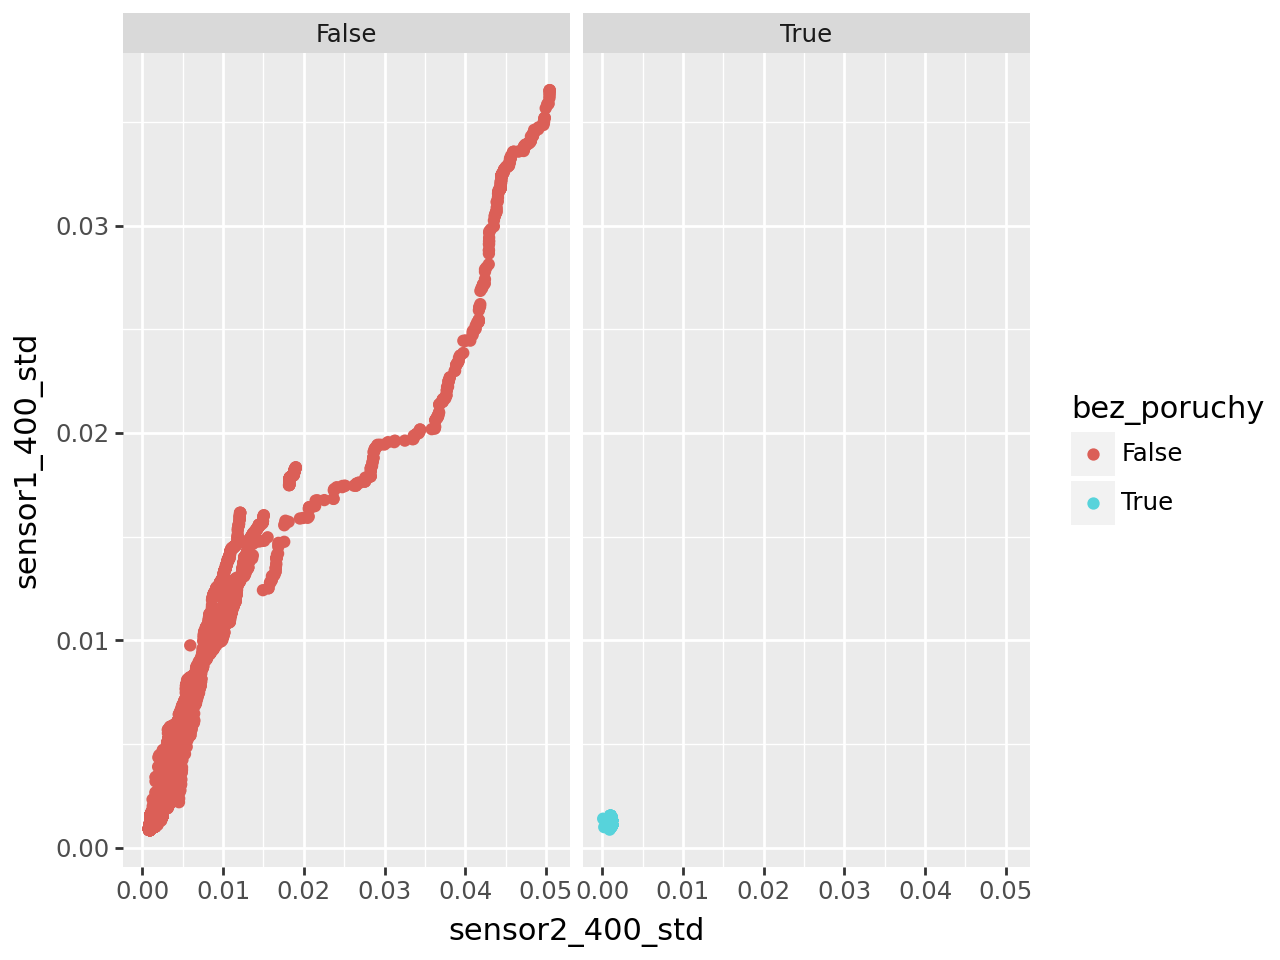

In [14]:
df_edit_viz = df_edit.copy()
df_edit_viz.state_expected.astype(str).iloc[0]
df_edit_viz['bez_poruchy'] = df_edit_viz['state_expected'] == 0

plot = (ggplot(data=df_edit_viz[(df_edit_viz.speedSet == 8.33203125) & (df_edit_viz.load_value == 0)],
               mapping=aes(x='sensor2_400_std', y='sensor1_400_std', color='bez_poruchy'))
        + geom_point()
        + facet_wrap('~bez_poruchy'))

display(plot)

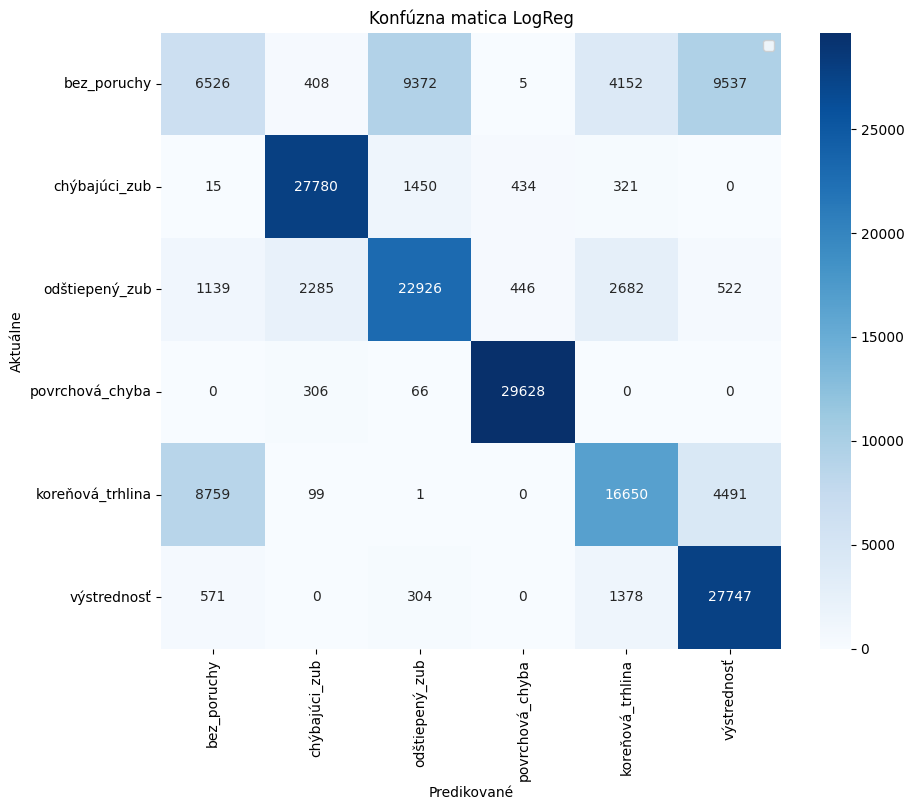

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
log_reg.classes_ = state_expected_keys.state.values
log_reg.classes_

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title('Konfúzna matica LogReg')
plt.legend([f'Presnosť: {accuracy_lr:.2f}'])
plt.show()

In [16]:
# Parameter grid for RandomizedSearch
param_grid_lgbm = {
    'num_leaves': [31],
    'min_data_in_leaf': [20],
    'max_depth': [-1],
    'learning_rate': [0.01],
    'n_estimators': [100]
}

lgb_model = lgb.LGBMClassifier()
test_times = []
time_start2 = time()
# Grid search
best_lgb_model = GridSearchCV(lgb_model, param_grid_lgbm, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
best_lgb_model.fit(X_train, y_train)
training_time = time() - time_start2
best_lgb = best_lgb_model.best_estimator_
time_test2 = time()
# Predict the test set
y_pred = best_lgb.predict(X_test)
test_times.append(time() - time_test2)

# Calculate the accuracy
accuracy_lgb = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_lgb))

# Save the model to a file
model_name = f'lightgbm_{accuracy_lgb:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_lgb, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_lgb}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_lgb.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12509
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 54
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Accuracy: 0.9794388888888889


None

Model and metadata saved in models


In [17]:
df_edit_ss = df_edit[(df_edit.speedSet == 8.33203125) & (df_edit.load_value == 80)]

df_edit_ss = df_edit_ss[(df_edit_ss.state_expected == 0) | (df_edit_ss.state_expected == 1)].copy()

df_edit_ss.sort_values(by = ['state_expected'], inplace = True)

In [18]:
# drop time normaliz
df_edit_ss['sensor1_25_max'] = df_edit_ss['sensor1'].rolling(window=25, min_periods=1).max()
df_edit_ss['sensor1_25_min'] = df_edit_ss['sensor1'].rolling(window=25, min_periods=1).min()
df_edit_ss['sensor1_25_mean'] = df_edit_ss['sensor1'].rolling(window=25, min_periods=1).mean()
df_edit_ss['sensor1_25_std'] = df_edit_ss['sensor1'].rolling(window=25, min_periods=1).std()
df_edit_ss['sensor1_25_median'] = df_edit_ss['sensor1'].rolling(window=25, min_periods=1).median()

df_edit_ss['sensor2_25_max'] = df_edit_ss['sensor2'].rolling(window=25, min_periods=1).max()
df_edit_ss['sensor2_25_min'] = df_edit_ss['sensor2'].rolling(window=25, min_periods=1).min()
df_edit_ss['sensor2_25_mean'] = df_edit_ss['sensor2'].rolling(window=25, min_periods=1).mean()
df_edit_ss['sensor2_25_std'] = df_edit_ss['sensor2'].rolling(window=25, min_periods=1).std()
df_edit_ss['sensor2_25_median'] = df_edit_ss['sensor2'].rolling(window=25, min_periods=1).median()

df_edit_ss['sensor1_50_max'] = df_edit_ss['sensor1'].rolling(window=50, min_periods=1).max()
df_edit_ss['sensor1_50_min'] = df_edit_ss['sensor1'].rolling(window=50, min_periods=1).min()
df_edit_ss['sensor1_50_mean'] = df_edit_ss['sensor1'].rolling(window=50, min_periods=1).mean()
df_edit_ss['sensor1_50_std'] = df_edit_ss['sensor1'].rolling(window=50, min_periods=1).std()
df_edit_ss['sensor1_50_median'] = df_edit_ss['sensor1'].rolling(window=50, min_periods=1).median()

df_edit_ss['sensor2_50_max'] = df_edit_ss['sensor2'].rolling(window=50, min_periods=1).max()
df_edit_ss['sensor2_50_min'] = df_edit_ss['sensor2'].rolling(window=50, min_periods=1).min()
df_edit_ss['sensor2_50_mean'] = df_edit_ss['sensor2'].rolling(window=50, min_periods=1).mean()
df_edit_ss['sensor2_50_std'] = df_edit_ss['sensor2'].rolling(window=50, min_periods=1).std()
df_edit_ss['sensor2_50_median'] = df_edit_ss['sensor2'].rolling(window=50, min_periods=1).median()

df_edit_ss['sensor1_100_max'] = df_edit_ss['sensor1'].rolling(window=100, min_periods=1).max()
df_edit_ss['sensor1_100_min'] = df_edit_ss['sensor1'].rolling(window=100, min_periods=1).min()
df_edit_ss['sensor1_100_mean'] = df_edit_ss['sensor1'].rolling(window=100, min_periods=1).mean()
df_edit_ss['sensor1_100_std'] = df_edit_ss['sensor1'].rolling(window=100, min_periods=1).std()
df_edit_ss['sensor1_100_median'] = df_edit_ss['sensor1'].rolling(window=100, min_periods=1).median()

df_edit_ss['sensor2_100_max'] = df_edit_ss['sensor2'].rolling(window=100, min_periods=1).max()
df_edit_ss['sensor2_100_min'] = df_edit_ss['sensor2'].rolling(window=100, min_periods=1).min()
df_edit_ss['sensor2_100_mean'] = df_edit_ss['sensor2'].rolling(window=100, min_periods=1).mean()
df_edit_ss['sensor2_100_std'] = df_edit_ss['sensor2'].rolling(window=100, min_periods=1).std()
df_edit_ss['sensor2_100_median'] = df_edit_ss['sensor2'].rolling(window=100, min_periods=1).median()

df_edit_ss['sensor1_200_max'] = df_edit_ss['sensor1'].rolling(window=200, min_periods=1).max()
df_edit_ss['sensor1_200_min'] = df_edit_ss['sensor1'].rolling(window=200, min_periods=1).min()
df_edit_ss['sensor1_200_mean'] = df_edit_ss['sensor1'].rolling(window=200, min_periods=1).mean()
df_edit_ss['sensor1_200_std'] = df_edit_ss['sensor1'].rolling(window=200, min_periods=1).std()
df_edit_ss['sensor1_200_median'] = df_edit_ss['sensor1'].rolling(window=200, min_periods=1).median()

df_edit_ss['sensor2_200_max'] = df_edit_ss['sensor2'].rolling(window=200, min_periods=1).max()
df_edit_ss['sensor2_200_min'] = df_edit_ss['sensor2'].rolling(window=200, min_periods=1).min()
df_edit_ss['sensor2_200_mean'] = df_edit_ss['sensor2'].rolling(window=200, min_periods=1).mean()
df_edit_ss['sensor2_200_std'] = df_edit_ss['sensor2'].rolling(window=200, min_periods=1).std()
df_edit_ss['sensor2_200_median'] = df_edit_ss['sensor2'].rolling(window=200, min_periods=1).median()

df_edit_ss['sensor1_400_max'] = df_edit_ss['sensor1'].rolling(window=400, min_periods=1).max()
df_edit_ss['sensor1_400_min'] = df_edit_ss['sensor1'].rolling(window=400, min_periods=1).min()
df_edit_ss['sensor1_400_mean'] = df_edit_ss['sensor1'].rolling(window=400, min_periods=1).mean()
df_edit_ss['sensor1_400_std'] = df_edit_ss['sensor1'].rolling(window=400, min_periods=1).std()
df_edit_ss['sensor1_400_median'] = df_edit_ss['sensor1'].rolling(window=400, min_periods=1).median()

df_edit_ss['sensor2_400_max'] = df_edit_ss['sensor2'].rolling(window=400, min_periods=1).max()
df_edit_ss['sensor2_400_min'] = df_edit_ss['sensor2'].rolling(window=400, min_periods=1).min()
df_edit_ss['sensor2_400_mean'] = df_edit_ss['sensor2'].rolling(window=400, min_periods=1).mean()
df_edit_ss['sensor2_400_std'] = df_edit_ss['sensor2'].rolling(window=400, min_periods=1).std()
df_edit_ss['sensor2_400_median'] = df_edit_ss['sensor2'].rolling(window=400, min_periods=1).median()

In [19]:
df_edit_ss_y = df_edit_ss.state_expected
df_edit_ss_x = df_edit_ss.drop(columns = ['state_expected', 'time_normalized', 'sample'])

# standardize the x

scaler = StandardScaler()
df_edit_ss_x = scaler.fit_transform(df_edit_ss_x)

df_edit_ss_predict = best_lgb.predict(df_edit_ss_x)

df_edit_ss['predicted'] = df_edit_ss_predict
df_edit_ss['indexer'] = df_edit_ss.reset_index(drop = True).index * 0.0002



c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [20]:
df_edit_ss['good_prediction'] = df_edit_ss.predicted == df_edit_ss.state_expected

In [21]:
df_edit_ss.predicted.value_counts()

# make predicted2 column, whne predicted is > 0 then return 1
df_edit_ss['predicted2'] = np.where(df_edit_ss['predicted'] > 0, 1, 0)
df_edit_ss['good_prediction2'] = df_edit_ss.predicted2 == df_edit_ss.state_expected

In [22]:
df_edit_ss['good_prediction2'].value_counts()

good_prediction2
True     31835
False    18165
Name: count, dtype: int64

In [23]:
2943*0.0002

0.5886

In [24]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from plotnine import ggplot, aes, geom_point, geom_line

# Plot
plot = (
    ggplot(df_edit_ss, aes(x='indexer'))
    + geom_point(aes(y = 'state_expected', color='factor(predicted2)'), alpha=0.5)  # Original data points
    + geom_vline(aes(xintercept = 5.5886))
)

print(plot)


<ggplot: (640 x 480)>


In [25]:
def find_first_above_threshold(df, window_size, threshold=0.95):
    """
    Identifies the first index where the rolling average of 'predicted2' exceeds a specified threshold.
    
    :param df: DataFrame containing the 'predicted2' column with prediction outcomes.
    :param window_size: Size of the rolling window to calculate the average.
    :param threshold: The threshold for the rolling average to identify the stopping point.
    :return: The 'indexer' value at the first point where the condition is met.
    """
    # Calculate the rolling average of predicted outcomes
    rolling_avg = df['predicted2'].rolling(window=window_size).mean()

    # Find the first index where the rolling average exceeds the threshold
    first_above_threshold = rolling_avg > threshold
    if first_above_threshold.any():
        first_index = first_above_threshold.idxmax()
        return df['indexer'][first_index]
    else:
        return None  # No point exceeds the threshold

# Example DataFrame setup
# df['predicted2'] should contain the probabilities or binary outcomes (1 or 0)
# df['indexer'] should be set up with the time or index values

# Usage
window_size = 500  # For example, check over 10 consecutive predictions
threshold_point = find_first_above_threshold(df_edit_ss, window_size)
if threshold_point is not None:
    print(f"Early stopping point at indexer: {threshold_point}")
else:
    print("No point exceeds the threshold within the given window.")


Early stopping point at indexer: 27262    0.4498
27262    5.4514
Name: indexer, dtype: float64


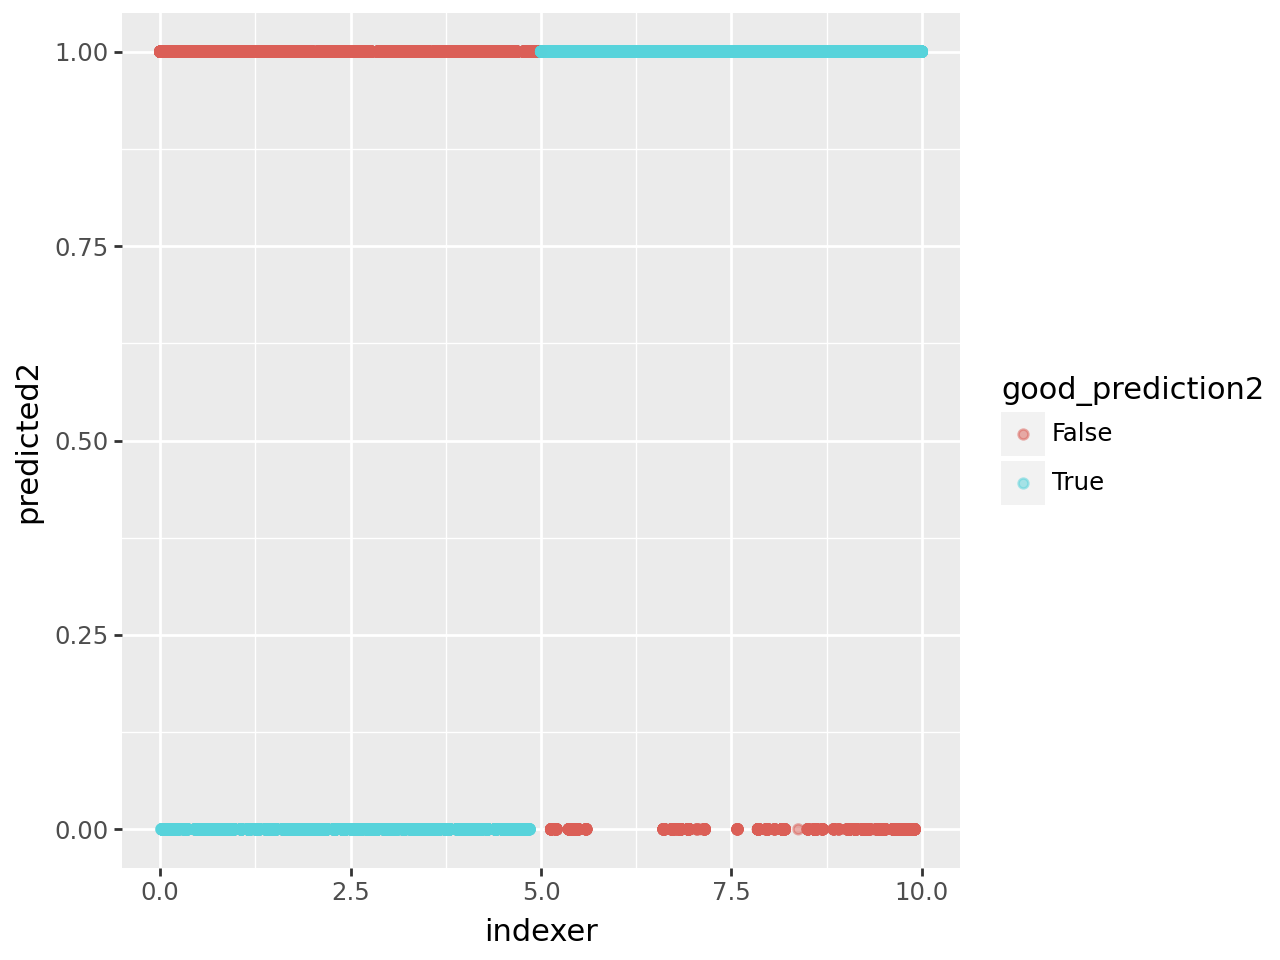

In [26]:
ggplot(data = df_edit_ss, mapping = aes(x = 'indexer', y = 'predicted2', color = 'good_prediction2')) + geom_point(alpha = 0.5)

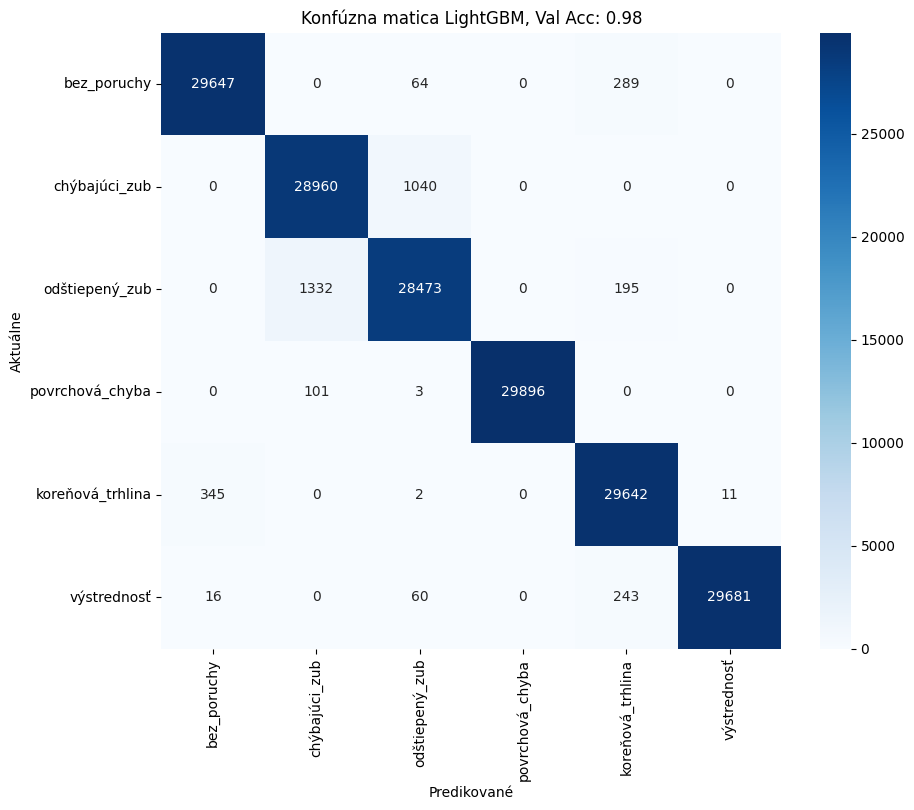

In [27]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names in someway
predicted_names = [mapping_dict[label] for label in best_lgb.classes_]
# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title(f'Konfúzna matica LightGBM, Val Acc: {accuracy_lgb:.2f}')
plt.show()

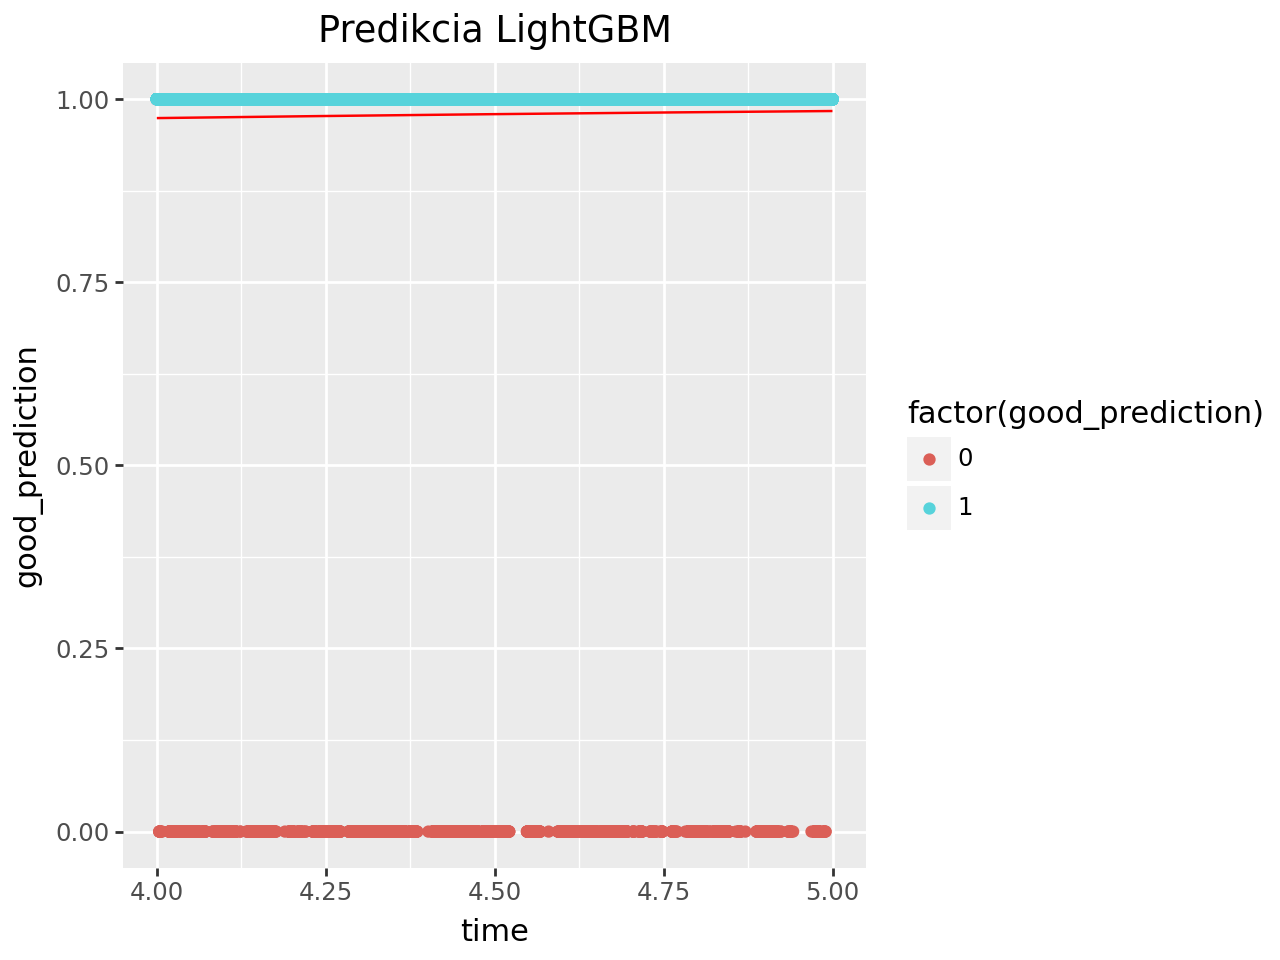

In [28]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='factor(good_prediction)')) +
                 geom_point() +
                 ggtitle('Predikcia LightGBM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [29]:
# Create XGB Classifier
param_grid_xgb = {
    'max_depth': [31],
    'min_child_weight': [0.001],
    'colsample_bytree': [1.0],
    'learning_rate': [0.1],
    'n_estimators': [100]
}

# Setup the model
xgb_model = xgb.XGBClassifier()

start_time3 = time()
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=4, verbose=1, scoring='accuracy', n_jobs=-1)
# Pick the best model
grid_search_xgb.fit(X_train, y_train)
training_time = time() - start_time3
best_xgb = best_lgb_model.best_estimator_
time_test3 = time()
# Predict the test set
y_pred = best_xgb.predict(X_test)
test_times.append(time() - time_test3)
# Calculate the accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_xgb))

# Print the validation accuracy
print(f'Validation Accuracy for LightGBM: {accuracy_xgb}')

# Save the model to a file
model_name = f'xgboost_{accuracy_xgb:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_xgb, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_xgb}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_xgb.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits


c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Accuracy: 0.9794388888888889


None

Validation Accuracy for LightGBM: 0.9794388888888889
Model and metadata saved in models


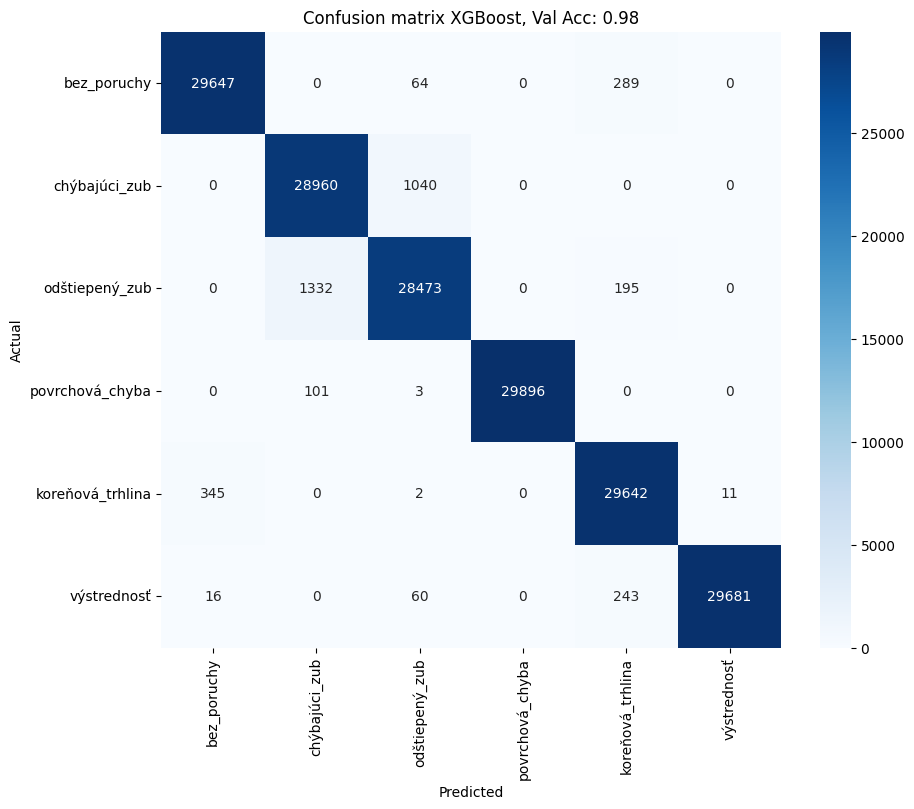

In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_xgb.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix XGBoost, Val Acc: {accuracy_xgb:.2f}')
plt.show()




In [31]:
len(y_pred)

180000

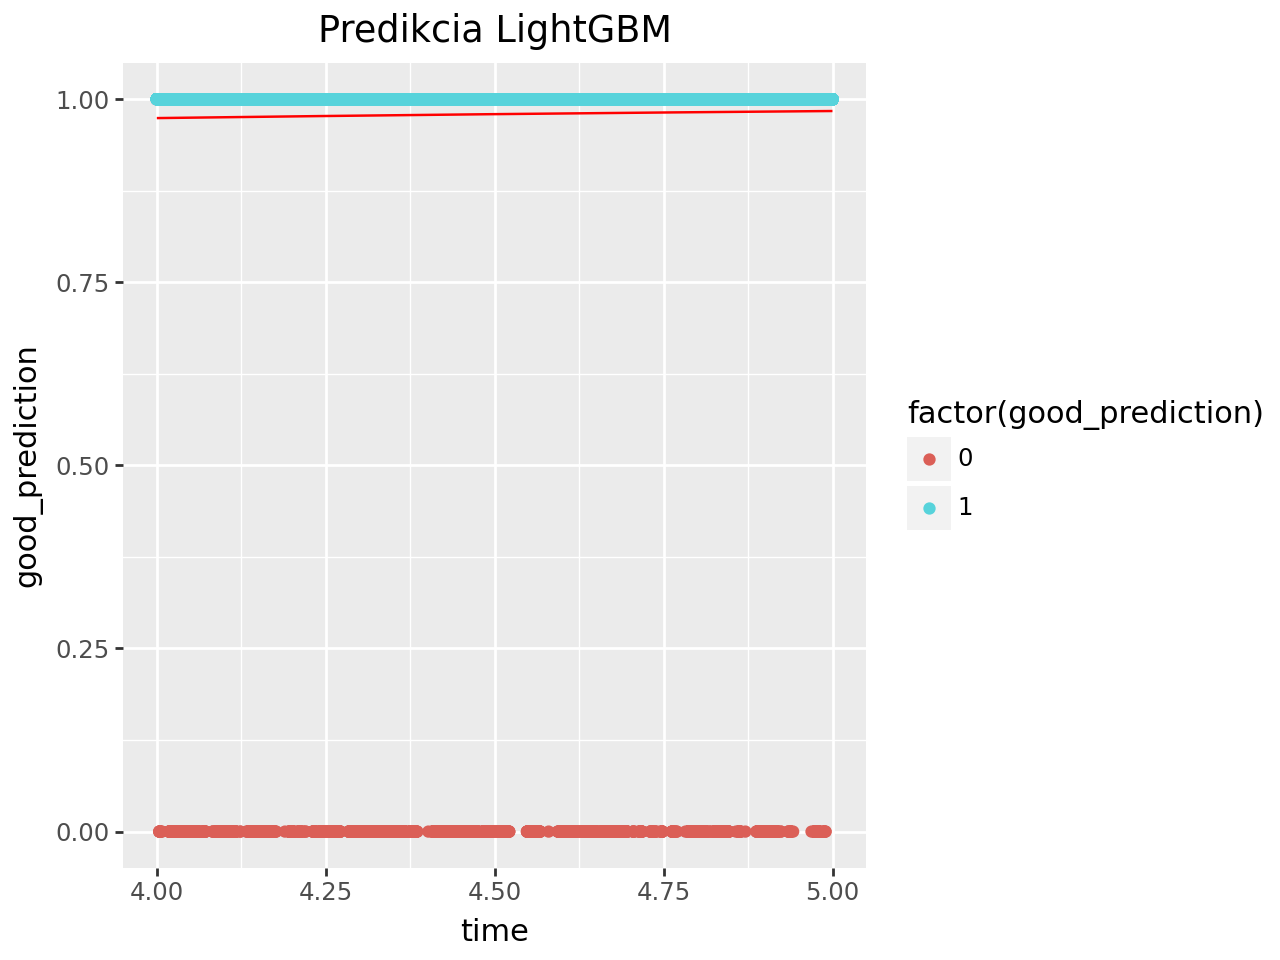

In [32]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='factor(good_prediction)')) +
                 geom_point() +
                 ggtitle('Predikcia LightGBM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [33]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [1]
}

# Setup the model
rf_model = RandomForestClassifier()

start_time5 = time()
# Pick the best model
best_rf_model = GridSearchCV(rf_model, param_grid_rf, cv=4, verbose=1, n_jobs=-1)
best_rf_model.fit(X_train, y_train)
start_time = time() - start_time5

best_rf = best_rf_model.best_estimator_
time_test5 = time()
# Predict the test set
y_pred = best_rf.predict(X_test)
test_times.append(time() - time_test5)
# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_rf))

# Print the validation accuracy
print(f'Validation Accuracy for RandomForest: {accuracy_rf}')

# Save the model to a file
model_name = f'random_forest_{accuracy_rf:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_rf, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_rf}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_rf.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Accuracy: 0.9804833333333334


None

Validation Accuracy for RandomForest: 0.9804833333333334
Model and metadata saved in models


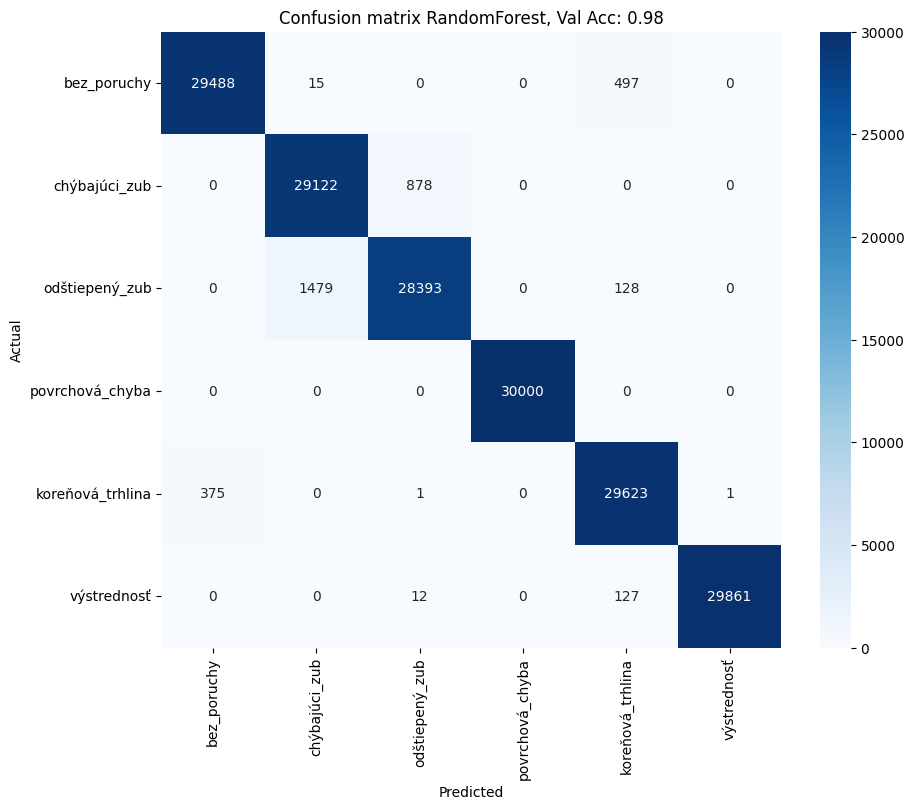

In [34]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_rf.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix RandomForest, Val Acc: {accuracy_rf:.2f}')
plt.show()

In [ ]:
# Construct the DataFrame with the original predictions
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred  # Use the main model’s predictions, length 180,000
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer['state'] == dfer['yval']).astype(int)

# Fit a logistic regression model for the curve
X = dfer[['time']].values
y = dfer['good_prediction'].values
logit_model = LogisticRegression()
logit_model.fit(X, y)

# Generate points for the logistic regression curve
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)
y_pred_logistic = logit_model.predict_proba(x_range)[:, 1]  # 300 probabilities

# Optionally, create a DataFrame for plotting the curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred_logistic})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

ValueError: Length of values (300) does not match length of index (180000)

In [ ]:
from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia RF'))

logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

print(logistic_plot)

In [ ]:
# Create a decision tree model for classification using the df dataset print the accuracy of the model
param_grid_dt = {
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [5]
}

# Setup the model
dt_model = DecisionTreeClassifier()

start_time6 = time()
# Pick the best model
best_dt_model = GridSearchCV(dt_model, param_grid_dt, cv=4, verbose=1, n_jobs=-1)
best_dt_model.fit(X_train, y_train)
start_time = time() - start_time6

best_dt = best_dt_model.best_estimator_
time_test6 = time()
# Predict the test set
y_pred = best_dt.predict(X_test)
test_times.append(time() - time_test6)

# Calculate the accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_dt))

# Print the validation accuracy
print(f'Validation Accuracy for DecisionTree: {accuracy_dt}')

# Save the model to a file
model_name = f'decision_tree_{accuracy_dt:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_dt, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_dt}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_dt.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_dt_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix DecisionTree, Val Acc: {accuracy_dt:.2f}')
plt.show()

In [ ]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class


from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction') +
                 geom_point() +
                 ggtitle('Predikcia DT')))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [ ]:
# Create a multilayer perceptron model for classification using the df dataset print the accuracy of the model
param_distributions_mlp = {
    'hidden_layer_sizes': [(150,), (160,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.05],
    'learning_rate': ['adaptive'],
}

# Setup the model
mlp_model = MLPClassifier()

start_time8 = time()
grid_search_mlp = GridSearchCV(mlp_model, param_distributions_mlp, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
# Pick the best model
best_mlp_model = grid_search_mlp.fit(X_train, y_train)
training_time = time() - start_time8

best_mlp = best_mlp_model.best_estimator_
time_test8 = time()
# Predict the test set
y_pred = best_mlp.predict(X_test)
test_times.append(time() - time_test8)
# Calculate the accuracy
accuracy_mlp = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_mlp))

# Save the model to a file
model_name = f'mlp_{accuracy_mlp:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_mlp, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_mlp}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {best_mlp.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

In [ ]:
# Print mlp architecture
print(best_mlp.get_params())

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_mlp.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix MLP, Val Acc: {accuracy_mlp:.2f}')
plt.show()

In [ ]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction') +
                 geom_point() +
                 ggtitle('Predikcia MLP')))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [ ]:
# Find the best models trained so far and print their names and validation accuracies and do feature importance the model
# with the highest validation accuracy
import shap

from sklearn.inspection import permutation_importance

models = {
    'lightGBM': accuracy_lgb,
    'xgboost': accuracy_xgb,
    #'knn': accuracy_knn,
    'random_forest': accuracy_rf,
    'decision_tree': accuracy_dt,
    #'svm': accuracy_svm,
    'mlp': accuracy_mlp,
}

# Find the best model
best_model_name = max(models, key=models.get)
best_model_accuracy = models[best_model_name]

print(f'Best model: {best_model_name}, Validation Accuracy: {best_model_accuracy}')

# Load the best model
best_model_path = f'models/{best_model_name}_{best_model_accuracy:.4f}.h5'
best_model = joblib.load(best_model_path)

# Feature importance
# If knn then we do it differently
if best_model_name == 'knn':
    # Perform permutation importance
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()
# And if mlp then we do it differently
elif best_model_name == 'mlp':
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()
elif best_model_name == 'svm':
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()

else:
    feature_imp = best_model.feature_importances_

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(X_test_not_scaled.columns, feature_imp)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance for {best_model_name} Model')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
    plt.show()
    
plt.savefig(f'plots/feature_importance_{best_model_name}_{best_model_accuracy:.4f}.png')

In [ ]:
# Transform y_test arrays values where the number does not equals 0 to 1
y_tests = np.where(y_test != 0, 1, 0)
unique, counts = np.unique(y_tests, return_counts=True)

from sklearn.metrics import roc_curve
# Directory containing the models
model_directory = 'models'
models = os.listdir(model_directory)
model_accuracies = {}

for model in models:
    if model.endswith('.h5'):
        # Split the filename to isolate the parts
        parts = model.rsplit('_', 1)  # This splits only at the last underscore
        model_name = '_'.join(parts[:-1])  # Rejoin all but the last part for the full model name
        accuracy_part = parts[-1].replace('.h5', '')  # The last part, without '.h5'
        
        try:
            model_accuracy = float(accuracy_part)  # Convert the accuracy part to float
            model_accuracies[model_name] = model_accuracy  # Store using model name
        except ValueError:
            print(f"Could not convert {accuracy_part} to float for model {model}")

# Find the model with the highest accuracy
if model_accuracies:
    best_model_name, best_model_accuracy = max(model_accuracies.items(), key=lambda item: item[1])
    print(f'Best model: {best_model_name}, Validation Accuracy: {best_model_accuracy}')
else:
    print("No valid model accuracies found.")

# Predict with the best model and evaluate, plot the confusion matrix and the ROC curve
# Load the best model
best_model_path = f'models/{best_model_name}_{best_model_accuracy:.4f}.h5'
best_model = joblib.load(best_model_path)

# Predict the test set
y_preds = best_model.predict(X_test)
y_preds = np.where(y_preds != 0, 1, 0)

# Calculate the accuracy
accuracy = accuracy_score(y_tests, y_preds)
display(print(f'Accuracy: {accuracy:.4f}'))

# Calculate the confusion matrix
cm = confusion_matrix(y_tests, y_preds)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bez_poruchy', 'fault'], yticklabels=['bez_poruchy', 'fault'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix for {best_model_name}, Test Acc: {accuracy:.2f}')
plt.show()
plt.savefig(f'plots/confusion_matrix_{best_model_name}_{best_model_accuracy:.4f}.png')
# Calculate the ROC curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_tests, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {best_model_name}')
plt.show()
plt.savefig(f'plots/roc_curve_{best_model_name}_{best_model_accuracy:.4f}.png')


In [ ]:
# Do the prediction for the training set
y_trains = np.where(y_train != 0, 1, 0)
y_train_preds = best_model.predict(X_train)
y_train_preds = np.where(y_train_preds != 0, 1, 0)
# Calculate the accuracy
accuracy_train = accuracy_score(y_trains, y_train_preds)
display(print(f'Accuracy: {accuracy_train:.4f}'))

In [ ]:
# Matrix
cm = confusion_matrix(y_trains, y_train_preds)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bez_poruchy', 'fault'], yticklabels=['bez_poruchy', 'fault'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix for {best_model_name}, Train Acc: {accuracy_train:.2f}')
plt.show()
plt.savefig(f'plots/confusion_matrix_train_{best_model_name}_{best_model_accuracy:.4f}.png')

In [ ]:
# Recall, Precision, F1-Score
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_trains, y_train_preds))

# Print the classification report
print(classification_report(y_tests, y_preds))


In [ ]:
# Merge X_train_not_scaled and y_train and X_test_not_scaled and y_test and then together
df_train = X_train_not_scaled.copy()
df_train['state_expected'] = y_train
df_test = X_test_not_scaled.copy()
df_test['state_expected'] = y_test
df_all = pd.concat([df_train, df_test])

In [ ]:
# Order by state_expected and time_normalized
df_all = df_all.sort_values(['state_expected', 'time_normalized']).reset_index(drop=True)


In [ ]:
# Pick state_expected column values where values equals 0
df_bez_poruchy = df_all.loc[df_all['state_expected'] == 0]
# Do it for other values 0 - 5 with for and create 6 unique datasets merged with the df_bez_poruchy 
for i in range(0, 6):
    df_fault = df_all.loc[df_all['state_expected'] == i]
    # Add 5 to time_normalized column values
    df_fault['time_normalized'] = df_fault['time_normalized'] + 5
    # Merge the 2 selected datasets to new datasets with new names without saving
    df_new = pd.concat([df_bez_poruchy, df_fault])
    # Save datasets
    df_new.to_csv(f'datasets/df_new_{i}.csv', index=False)


    

In [ ]:
# Load the datasets
df_new_0 = pd.read_csv('datasets/df_new_0.csv')
df_new_1 = pd.read_csv('datasets/df_new_1.csv')
df_new_2 = pd.read_csv('datasets/df_new_2.csv')
df_new_3 = pd.read_csv('datasets/df_new_3.csv')
df_new_4 = pd.read_csv('datasets/df_new_4.csv')
df_new_5 = pd.read_csv('datasets/df_new_5.csv')
# Find and load lgb model with highest acc
models = {
    'lightGBM': accuracy_lgb,
    'xgboost': accuracy_xgb,
    #'knn': accuracy_knn,
    'random_forest': accuracy_rf,
    'decision_tree': accuracy_dt,
    #'svm': accuracy_svm,
    'mlp': accuracy_mlp,
}

In [ ]:
# Find lgbm model with highest accuracy
# Define the directory containing the models
model_directory = 'models'  # Adjust path as needed
best_model_path = None
highest_accuracy = 0
model_names = 'lightgbm_'

# Iterate through each file in the directory
for filename in os.listdir(model_directory):
    if filename.startswith(model_names) and filename.endswith(".h5"):
        # Extract accuracy from filename
        accuracy = float(filename.split('_')[1].replace('.h5', ''))
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_model_path = os.path.join(model_directory, filename)

# Load the best model if found
if best_model_path:
    model_resp = joblib.load(best_model_path)
    print(f"Best model loaded: {best_model_path} with accuracy {highest_accuracy}")
else:
    print("No LightGBM model files found.")

# Dynamically predict the state_expected column values for each dataset and print the accuracy
# Create a dictionary to hold the datasets
datasets = {
    'df_new_0': df_new_0,
    'df_new_1': df_new_1,
    'df_new_2': df_new_2,
    'df_new_3': df_new_3,
    'df_new_4': df_new_4,
    'df_new_5': df_new_5
}

# Create a dictionary to hold the accuracies
lgb_accuracies = {}
pred_data = {}
# Iterate over the datasets
for name, dataset in datasets.items():
    # Separate the features and target variable
    X = dataset.drop(columns=['state_expected'])
    y = dataset['state_expected']
    # Use standardscaler on X
    X = scaler.transform(X)
    # Predict the target variable
    lgb_y_pred = model_resp.predict(X)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y, lgb_y_pred)
    lgb_accuracies[name] = accuracy
    display(print(f'Accuracy for {name}: {accuracy:.4f}'))
    # Save every iteration of predictions
    pred_data[name + model_names] = lgb_y_pred

    # DataFrame setup
    dfer = y.reset_index(drop=True).to_frame(name='yval')
    dfer['time'] = df_new_0['time_normalized'].reset_index(drop=True)
    dfer['state'] = lgb_y_pred
    dfer['range'] = dfer.index
    dfer['good_prediction'] = (dfer['state'] == dfer['yval']).astype(int)

    # Filter to keep only the middle 40% of the data
    total_count = len(dfer)
    lower_bound = int(total_count * 0.3)  # Adjust to 30%
    upper_bound = int(total_count * 0.7)  # Adjust to 70%
    dfer = dfer.loc[lower_bound:upper_bound]

    # Prepare for logistic regression curve (must ensure this part makes sense for your analysis)
    x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)
    avg_roll = dfer['good_prediction'].rolling(window=int(len(dfer)*0.1), min_periods=1).mean()  # Adjust window size

    # Plotting setup
    original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')
                    + geom_point()
                    + ggtitle('Reakcia')))

    # Create a DataFrame for plotting - ensuring avg_roll matches x_range in length
    logistic_df = pd.DataFrame({
        'time': np.linspace(dfer['time'].min(), dfer['time'].max(), len(avg_roll)),
        'probability': avg_roll
    })

    # Add the logistic curve to the plot
    logistic_plot = (original_plot + 
                    geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

    print(logistic_plot)

In [ ]:
# Find lgbm model with highest accuracy
# Define the directory containing the models
model_directory = 'models'  # Adjust path as needed
best_model_path = None
highest_accuracy = 0
xgb_accuracies = {}
model_names = 'xgboost_'

# Iterate through each file in the directory
for filename in os.listdir(model_directory):
    if filename.startswith(model_names) and filename.endswith(".h5"):
        # Extract accuracy from filename
        accuracy = float(filename.split('_')[1].replace('.h5', ''))
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_model_path = os.path.join(model_directory, filename)

# Load the best model if found
if best_model_path:
    #best_model_path = f'models/{best_model_name}_{highest_accuracy:.4f}.h5'
    model_resp = joblib.load(best_model_path)
    print(f"Best model loaded: {best_model_path} with accuracy {highest_accuracy}")
else:
    print("No LightGBM model files found.")
# Iterate over the datasets
for name, dataset in datasets.items():
    # Separate the features and target variable
    X = dataset.drop(columns=['state_expected'])
    y = dataset['state_expected']
    # Use standardscaler on X
    X = scaler.transform(X)
    # Predict the target variable
    xgb_y_pred = model_resp.predict(X)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y, xgb_y_pred)
    xgb_accuracies[name] = accuracy
    display(print(f'Accuracy for {name}: {accuracy:.4f}'))
    # Save every iteration of predictions
    pred_data[name + model_names] = xgb_y_pred

    

In [ ]:
## Find lgbm model with highest accuracy
# Define the directory containing the models
model_directory = 'models'  # Adjust path as needed
best_model_path = None
highest_accuracy = 0
rf_accuracies = {}
model_names = 'random_forest_'

for filename in os.listdir(model_directory):
    if filename.startswith(model_names) and filename.endswith(".h5"):
        # Correctly split the filename and extract the accuracy
        parts = filename.split('_')
        # Assuming the accuracy part is always the second last element before ".h5"
        accuracy_part = parts[-1].replace('.h5', '')
        accuracy = float(accuracy_part)
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_model_path = os.path.join(model_directory, filename)

# Load the best model if found
if best_model_path:
    #best_model_path = f'models/{best_model_name}_{highest_accuracy:.4f}.h5'
    model_resp = joblib.load(best_model_path)
    print(f"Best model loaded: {best_model_path} with accuracy {highest_accuracy}")
else:
    print("No LightGBM model files found.")
# Iterate over the datasets
for name, dataset in datasets.items():
    # Separate the features and target variable
    X = dataset.drop(columns=['state_expected'])
    y = dataset['state_expected']
    # Use standardscaler on X
    X = scaler.transform(X)
    # Predict the target variable
    rf_y_pred = model_resp.predict(X)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y, rf_y_pred)
    rf_accuracies[name] = accuracy
    display(print(f'Accuracy for {name}: {accuracy:.4f}'))
    # Save every iteration of predictions
    pred_data[name + model_names] = rf_y_pred

In [ ]:
## Find lgbm model with highest accuracy
# Define the directory containing the models
model_directory = 'models'  # Adjust path as needed
best_model_path = None
highest_accuracy = 0
dt_accuracies = {}
model_names = 'decision_tree_'

for filename in os.listdir(model_directory):
    if filename.startswith(model_names) and filename.endswith(".h5"):
        # Correctly split the filename and extract the accuracy
        parts = filename.split('_')
        # Assuming the accuracy part is always the second last element before ".h5"
        accuracy_part = parts[-1].replace('.h5', '') 
        accuracy = float(accuracy_part)
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_model_path = os.path.join(model_directory, filename)

# Load the best model if found
if best_model_path:
    #best_model_path = f'models/{best_model_name}_{highest_accuracy:.4f}.h5'
    model_resp = joblib.load(best_model_path)
    print(f"Best model loaded: {best_model_path} with accuracy {highest_accuracy}")
else:
    print("No LightGBM model files found.")
# Iterate over the datasets
for name, dataset in datasets.items():
    # Separate the features and target variable
    X = dataset.drop(columns=['state_expected'])
    y = dataset['state_expected']
    # Use standardscaler on X
    X = scaler.transform(X)
    # Predict the target variable
    dt_y_pred = model_resp.predict(X)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y, dt_y_pred)
    dt_accuracies[name] = accuracy
    display(print(f'Accuracy for {name}: {accuracy:.4f}'))
    # Save every iteration of predictions
    pred_data[name + model_names] = dt_y_pred

In [ ]:
## Find lgbm model with highest accuracy
# Define the directory containing the models
model_directory = 'models'  # Adjust path as needed
best_model_path = None
highest_accuracy = 0
mlp_accuracies = {}
model_names = 'mlp_'

# Iterate through each file in the directory
for filename in os.listdir(model_directory):
    if filename.startswith(model_names) and filename.endswith(".h5"):
        # Extract accuracy from filename
        accuracy = float(filename.split('_')[1].replace('.h5', ''))
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_model_path = os.path.join(model_directory, filename)

# Load the best model if found
if best_model_path:
    #best_model_path = f'models/{best_model_name}_{highest_accuracy:.4f}.h5'
    model_resp = joblib.load(best_model_path)
    print(f"Best model loaded: {best_model_path} with accuracy {highest_accuracy}")
else:
    print("No LightGBM model files found.")
# Iterate over the datasets
for name, dataset in datasets.items():
    # Separate the features and target variable
    X = dataset.drop(columns=['state_expected'])
    y = dataset['state_expected']
    # Use standardscaler on X
    X = scaler.transform(X)
    # Predict the target variable
    mlp_y_pred = model_resp.predict(X)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y, mlp_y_pred)
    mlp_accuracies[name] = accuracy
    display(print(f'Accuracy for {name}: {accuracy:.4f}'))
    # Save every iteration of predictions
    pred_data[name + model_names] = mlp_y_pred

In [ ]:
# Create and avarage accuracy for each model and select the best one
# Calculate the average accuracy for each model
lgb_accuracies_avg = np.mean(list(lgb_accuracies.values()))
xgb_accuracies_avg = np.mean(list(xgb_accuracies.values()))
rf_accuracies_avg = np.mean(list(rf_accuracies.values()))
dt_accuracies_avg = np.mean(list(dt_accuracies.values()))
mlp_accuracies_avg = np.mean(list(mlp_accuracies.values()))

# Create a dictionary to hold the average accuracies
avg_accuracies = {
    'lightGBM': lgb_accuracies_avg,
    'xgboost': xgb_accuracies_avg,
    'random_forest': rf_accuracies_avg,
    'decision_tree': dt_accuracies_avg,
    'mlp': mlp_accuracies_avg
}

# Find the model with the highest average accuracy
best_model_name = max(avg_accuracies, key=avg_accuracies.get)
best_model_accuracy = avg_accuracies[best_model_name]

# Display model with the least test time from time_test
best_model_time = min(test_times)
display(print(f'Best model: {best_model_name}, Average Accuracy: {best_model_accuracy:.4f}'))

# Now with the same with avarage accuracy
lgb_accuracies_avgs = np.average(list(lgb_accuracies.values()))
xgb_accuracies_avgs = np.average(list(xgb_accuracies.values()))
#knn_accuracies_avgs = np.average(list(knn_accuracies.values())
rf_accuracies_avgs = np.average(list(rf_accuracies.values()))
dt_accuracies_avgs = np.average(list(dt_accuracies.values()))
#svc_accuracies_avgs = np.average(list(svc_accuracies.values())
mlp_accuracies_avgs = np.average(list(mlp_accuracies.values()))

# Create a dictionary to hold the average accuracies
avg_accuracies = {
    'lightGBM': lgb_accuracies_avgs,
    'xgboost': xgb_accuracies_avgs,
    'random_forest': rf_accuracies_avgs,
    'decision_tree': dt_accuracies_avgs,
    'mlp': mlp_accuracies_avgs
}

# Find the model with the highest average accuracy
best_model_name = max(avg_accuracies, key=avg_accuracies.get)
best_model_accuracy = avg_accuracies[best_model_name]

display(print(f'Best model: {best_model_name}, Average Accuracy: {best_model_accuracy:.4f}'))






In [ ]:
display(test_times)
#lgb_accuracies_avgs = np.average(list(lgb_accuracies.values())
#xgb_accuracies_avgs = np.average(list(xgb_accuracies.values())
#knn_accuracies_avgs = np.average(list(knn_accuracies.values())
#rf_accuracies_avgs = np.average(list(rf_accuracies.values())
#dt_accuracies_avgs = np.average(list(dt_accuracies.values())
#svc_accuracies_avgs = np.average(list(svc_accuracies.values())
#mlp_accuracies_avgs = np.average(list(mlp_accuracies.values())

In [ ]:
# Find lgbm model with highest accuracy
# Define the directory containing the models
model_directory = 'models'  # Adjust path as needed
best_model_path = None
highest_accuracy = 0
model_names = 'lightgbm_'

# Iterate through each file in the directory
for filename in os.listdir(model_directory):
    if filename.startswith(model_names) and filename.endswith(".h5"):
        # Extract accuracy from filename
        accuracy = float(filename.split('_')[1].replace('.h5', ''))
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_model_path = os.path.join(model_directory, filename)

# Load the best model if found
if best_model_path:
    model_retr = joblib.load(best_model_path)
    print(f"Best model loaded: {best_model_path} with accuracy {highest_accuracy}")
else:
    print("No LightGBM model files found.")

# Retrain model with the best model
# Separate the features and target variable
X = X_train
y = y_train

# Retrain the model
model_retr.fit(X, y)

# Print accuracy
accuracy = accuracy_score(y, model_retr.predict(X))
display(print(f'Accuracy: {accuracy:.4f}'))

# Dynamically predict the state_expected column values for each dataset and print the accuracy
# Transform df_new_2['state_expected'] values to 1 as only for the 2nd half of the dataset
df_new_2['state_expected'] = np.where(df_new_1['state_expected'] != 0, 1, 0)
df_new_3['state_expected'] = np.where(df_new_1['state_expected'] != 0, 1, 0)
df_new_4['state_expected'] = np.where(df_new_1['state_expected'] != 0, 1, 0)
df_new_5['state_expected'] = np.where(df_new_1['state_expected'] != 0, 1, 0)
# Create a dictionary to hold the datasets
datasets = {
    'df_new_0': df_new_0,
    'df_new_1': df_new_1,
    'df_new_2': df_new_2,
    'df_new_3': df_new_3,
    'df_new_4': df_new_4,
    'df_new_5': df_new_5
}

# Create a dictionary to hold the accuracies
lgbs_accuracies = {}
preds_data = {}
# Iterate over the datasets
for name, dataset in datasets.items():
    # Separate the features and target variable
    X = dataset.drop(columns=['state_expected'])
    y = dataset['state_expected']
    display(len(y))
    # Use standardscaler on X
    X = scaler.transform(X)
    # Predict the target variable
    lgb_y_pred = model_retr.predict(X)
    display(len(lgb_y_pred))
    # Where the number does not equals 0 to 1 for lgb_y_pred
    lgb_y_pred = np.where(lgb_y_pred != 0, 1, 0)
    # Calculate the accuracy
    accuracy = accuracy_score(y, lgb_y_pred)
    lgb_accuracies[name] = accuracy
    display(print(f'Accuracy for {name}: {accuracy:.4f}'))
    # Save every iteration of predictions
    pred_data[name + model_names] = lgb_y_pred

    # DataFrame setup
    dfer = y.reset_index(drop=True).to_frame(name='yval')
    dfer['time'] = df_new_0['time_normalized'].reset_index(drop=True)
    dfer['state'] = lgb_y_pred
    dfer['range'] = dfer.index
    dfer['good_prediction'] = (dfer['state'] == dfer['yval']).astype(int)

    # Filter to keep only the middle 40% of the data
    total_count = len(dfer)
    lower_bound = int(total_count * 0.3)  # Adjust to 30%
    upper_bound = int(total_count * 0.7)  # Adjust to 70%
    dfer = dfer.loc[lower_bound:upper_bound]

    # Prepare for logistic regression curve (must ensure this part makes sense for your analysis)
    x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)
    avg_roll = dfer['good_prediction'].rolling(window=int(len(dfer)*0.1), min_periods=1).mean()  # Adjust window size

    # Plotting setup
    original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')
                    + geom_point()
                    + ggtitle('Reakcia')))

    # Create a DataFrame for plotting - ensuring avg_roll matches x_range in length
    logistic_df = pd.DataFrame({
        'time': np.linspace(dfer['time'].min(), dfer['time'].max(), len(avg_roll)),
        'probability': avg_roll
    })

    # Add the logistic curve to the plot
    logistic_plot = (original_plot + 
                    geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

    print(logistic_plot)